In [1]:
# executing this cell will install all required julia packages
import Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.precompile()

 Activating environment at `~/Documents/Harvard/Miratrix/GeoRDD/notebooks/Project.toml`
Precompiling project...


In [2]:
do_savefig = false
figures_dir = "insert/path/where/figures/should/be/saved/"
;

In [3]:
using LaTeXStrings
using GaussianProcesses
import GeoInterface
using Distributions
import LibGEOS
using LibGEOS: LineString, geomLength, interpolate, nearestPoints
using LibGEOS: Point
using Distances
import Random
import Random: rand
import PyPlot; plt=PyPlot
using Printf

plt.rc("figure", dpi=120.0)
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
plt.rc("pdf", fonttype=42)
;

In [4]:
using GeoRDD

This notebook contains a simulation designed to show the problem with the density-weighted estimator.
Because the estimate ignores the covariance structure, it will give more weight to points along the boundary that are in wiggly sections, assuming all points are made equidistant.

To show this, I will create a boundary that is a triangular wave (zig-zag) between $x=0$ and $x=0.5$, and then just a straight line. The treatment effect isn't constant: it increases linearly from 0 at $x=0$ to 2 at $x=1$. That way, we will see that when the wiggly segment gains more influence, the estimate decreases. To distinguish the unweighted estimator from the density-weighted estimator, I also increase the density linearly with $x$. To avoid any confusion, I use the *true* density rather than an estimated density for the density-weighted estimator: the effect of the density estimation is irrelevant to the effect I wish to demonstrate.

# Setup

In [5]:
function border_line(numwiggles::Integer, A::Number)
    @assert numwiggles >= 0
    if numwiggles == 0
        line = [[0.0,0.0], [2.0,0.0]]
        return LineString(line)
    end
        
    x_left = collect(range(0, stop=0.5, length=numwiggles*4+1))
    y_left = repeat([0.0, A/2, 0.0, -A/2], outer=numwiggles)
    x = [x_left; 2.0]
    y = [y_left; 0.0; 0.0]
    @assert length(x) == length(y)
    
    line = [[xi, yi] for (xi,yi) in zip(x,y)]
    return LineString(line)
end

# define boundary:
# below 0.5: triangular wave
# above 0.5: straight line
bins = [0.0, 0.5, 1.5, 2.0]
densities = [1.0, 0.3, 2.0]

function wb_density(x)
    if x < bins[2]
        return densities[1]
    elseif x < bins[3]
        return densities[2]
    else
        return densities[3]
    end
end

# define treatment effect 
function wb_τx(x)
    return x
end
;

In [6]:
wb_xx = range(0.0,stop=2.0,length=1000)
mean([wb_τx(x) for x in wb_xx])

0.9999999999999999

In this simulation setting, we can know the true value of the estimand. We will define the estimand as the density-weighted treatment effect when there are no wiggles. That way the grid of points along the boundary is evenly spaced, and the estimand is easily interpretable. We use $\rho(x)$ for the true population density at $x$.

$$ \tau = \frac{\int_0^1 \left. \tau(x) \rho(x) dx \right.}{\int_0^1 \left. \rho(x) dx \right.}$$

In [7]:
wb_xx = range(0.0,stop=2.0,length=1000)
sum([wb_τx(x)*wb_density(x) for x in wb_xx])/sum([wb_density(x) for x in wb_xx])

1.2085418752085413

# Simulate

In [8]:
wb_A = 0.1
pw = diff(bins).*densities
X1distr = MixtureModel(
    [Uniform(bins[i],bins[i+1]) for i in 1:length(densities)],
    Categorical(pw ./ sum(pw))
    )
X2distr_treat = Uniform(wb_A/2, 1.0)
X2distr_ctrol = Uniform(-1.0, -wb_A/2)

struct SimulationSetting
    n::Int
    X_treat::Matrix
    X_ctrol::Matrix
    kern::Kernel
    σy2::Float64
    τx::Function
    prior::MultivariateNormal
    treat::Vector{Bool}
end

function SimulationSetting(X_treat::Matrix, X_ctrol::Matrix, kern::Kernel, σy2::Float64, τx::Function)
    ntreat = size(X_treat, 2)
    nctrol = size(X_ctrol, 2)
    n = ntreat + nctrol
    μprior=zeros(n)
    treat = [ones(Bool,wb_ntreat);zeros(Bool,wb_nctrol)]
    Σprior = GaussianProcesses.cov(kern, [X_treat X_ctrol])
    for i in 1:wb_n
        Σprior[i,i] += σy2
    end
    prior = MultivariateNormal(μprior, Σprior)
    return SimulationSetting(n, X_treat, X_ctrol, kern, σy2, τx, prior, treat)
end

function rand(sim::SimulationSetting)
    Y = rand(sim.prior)
    Ytreat = view(Y, sim.treat)
    Yctrol = view(Y, .!sim.treat)
    ntreat = size(sim.X_treat, 2)
    for i in 1:ntreat
        Ytreat[i] += sim.τx(sim.X_treat[1, i])
    end
    return Y, Ytreat, Yctrol
end
;

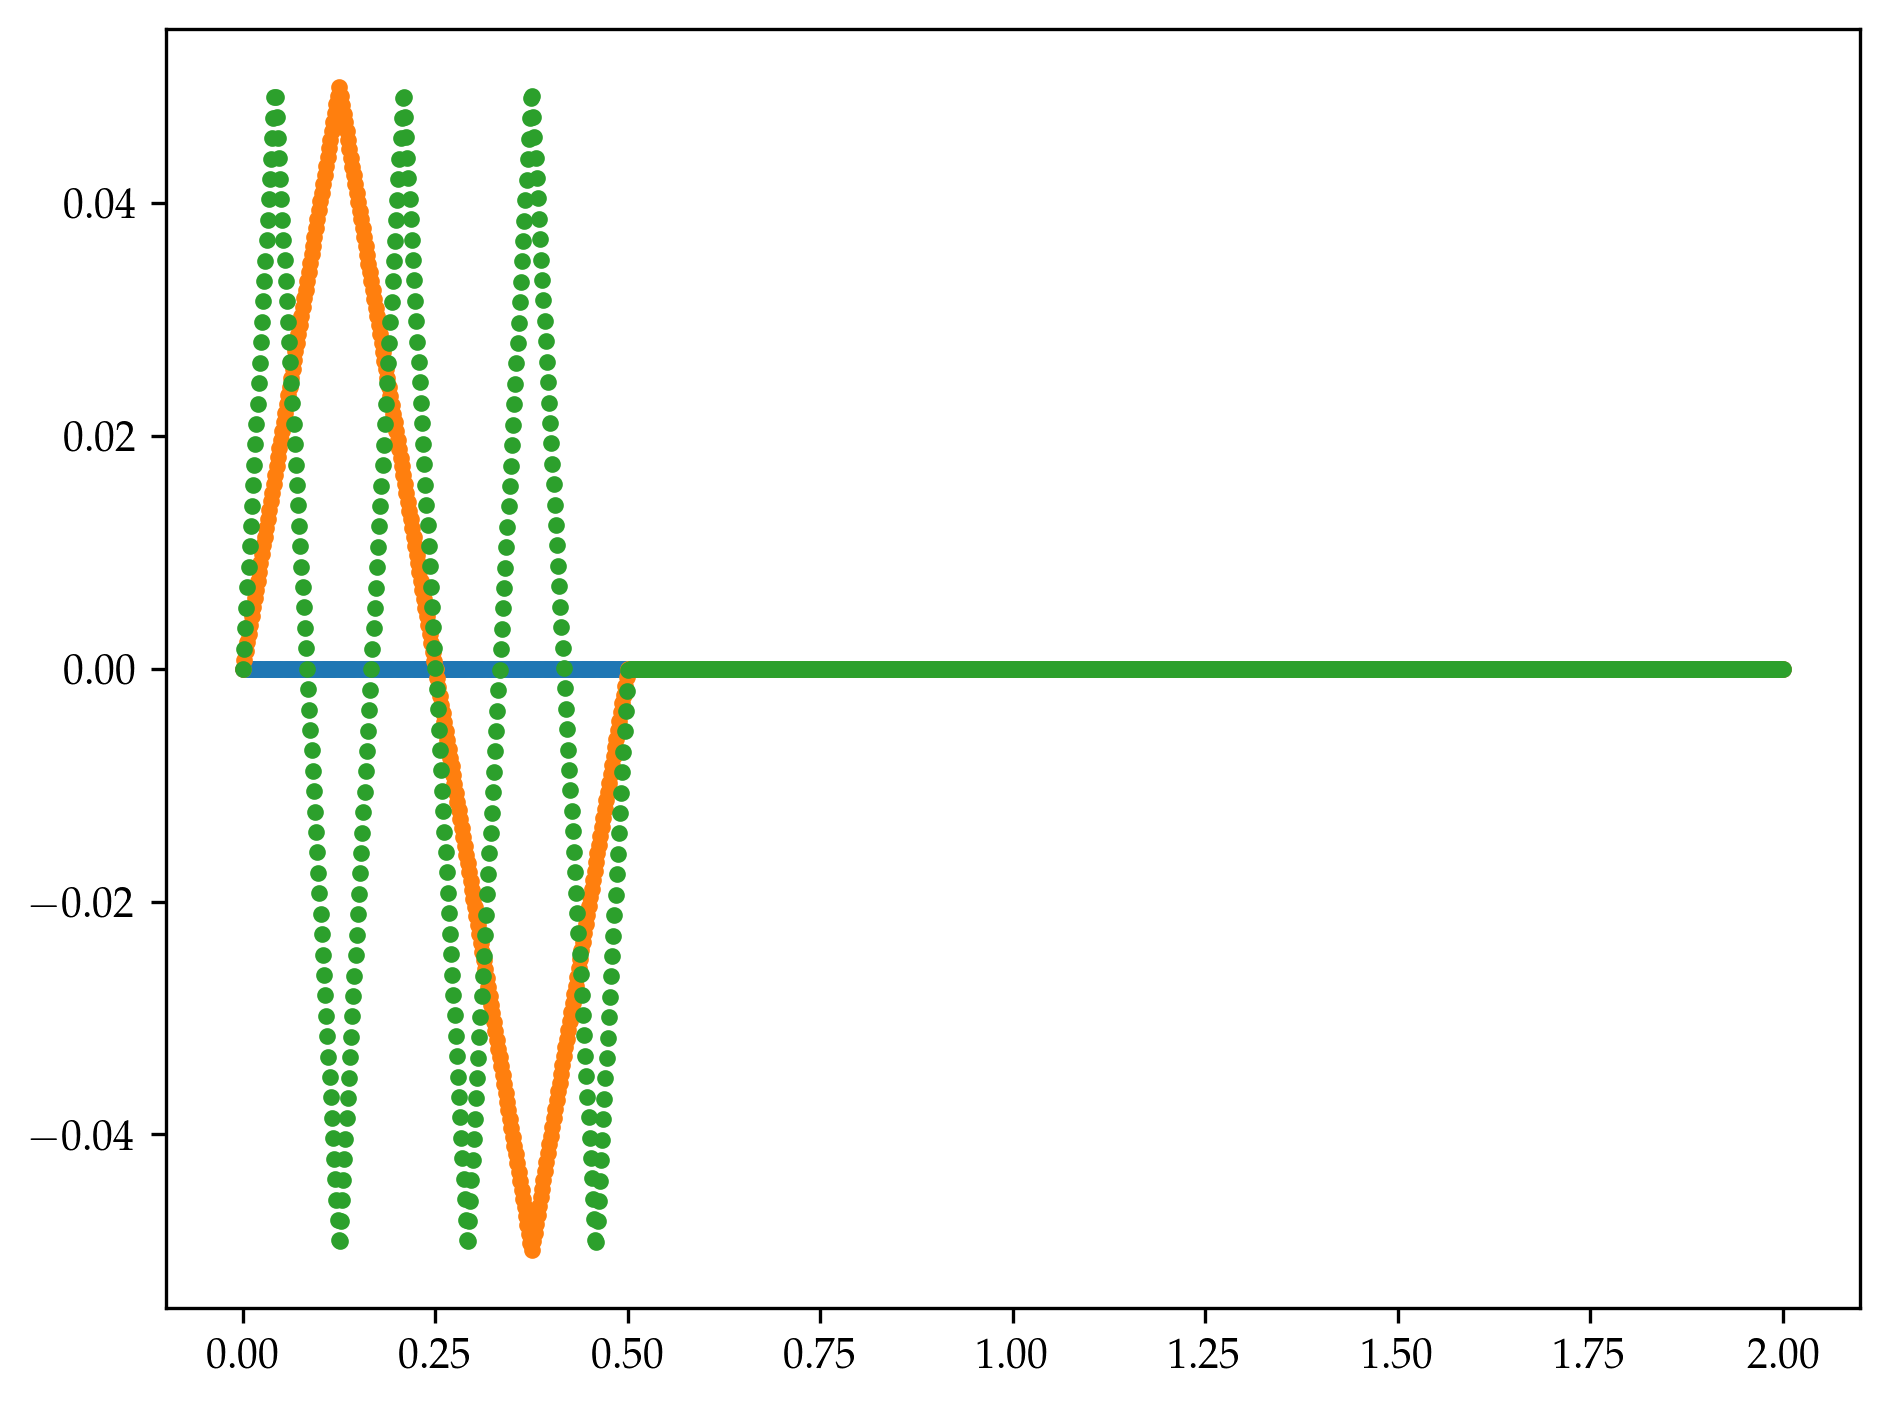

In [9]:
_Xb = GeoRDD.sentinels(border_line(0, wb_A), 1000)
plt.plot(_Xb[1,:], _Xb[2,:], ".")
_Xb = GeoRDD.sentinels(border_line(1, wb_A), 1000)
plt.plot(_Xb[1,:], _Xb[2,:], ".")
_Xb = GeoRDD.sentinels(border_line(3, wb_A), 1000)
plt.plot(_Xb[1,:], _Xb[2,:], ".")
;

In [10]:
Random.seed!(1)

wb_nwiggles = 5
wb_n = 200
wb_ntreat = 100
wb_nctrol = wb_n-wb_ntreat
wbX_treat = [rand(X1distr, wb_ntreat)'; 
             rand(X2distr_treat, wb_ntreat)']
wbX_ctrol = [rand(X1distr, wb_nctrol)'; 
             rand(X2distr_ctrol, wb_nctrol)']

wb_border = border_line(wb_nwiggles, wb_A)
border_points = [interpolate(wb_border,q) for q in range(0,stop=geomLength(wb_border),length=1000)]
border_coords = [GeoInterface.coordinates(p) for p in border_points]
border_x = [p[1] for p in border_coords]
border_y = [p[2] for p in border_coords]



wb_kern = Mat12Iso(log(0.4), log(0.5))
wb_σy2 = 0.1^2
sim = SimulationSetting(wbX_treat, wbX_ctrol, wb_kern, wb_σy2, wb_τx)
wb_Y, wb_Ytreat, wb_Yctrol = rand(sim)
;

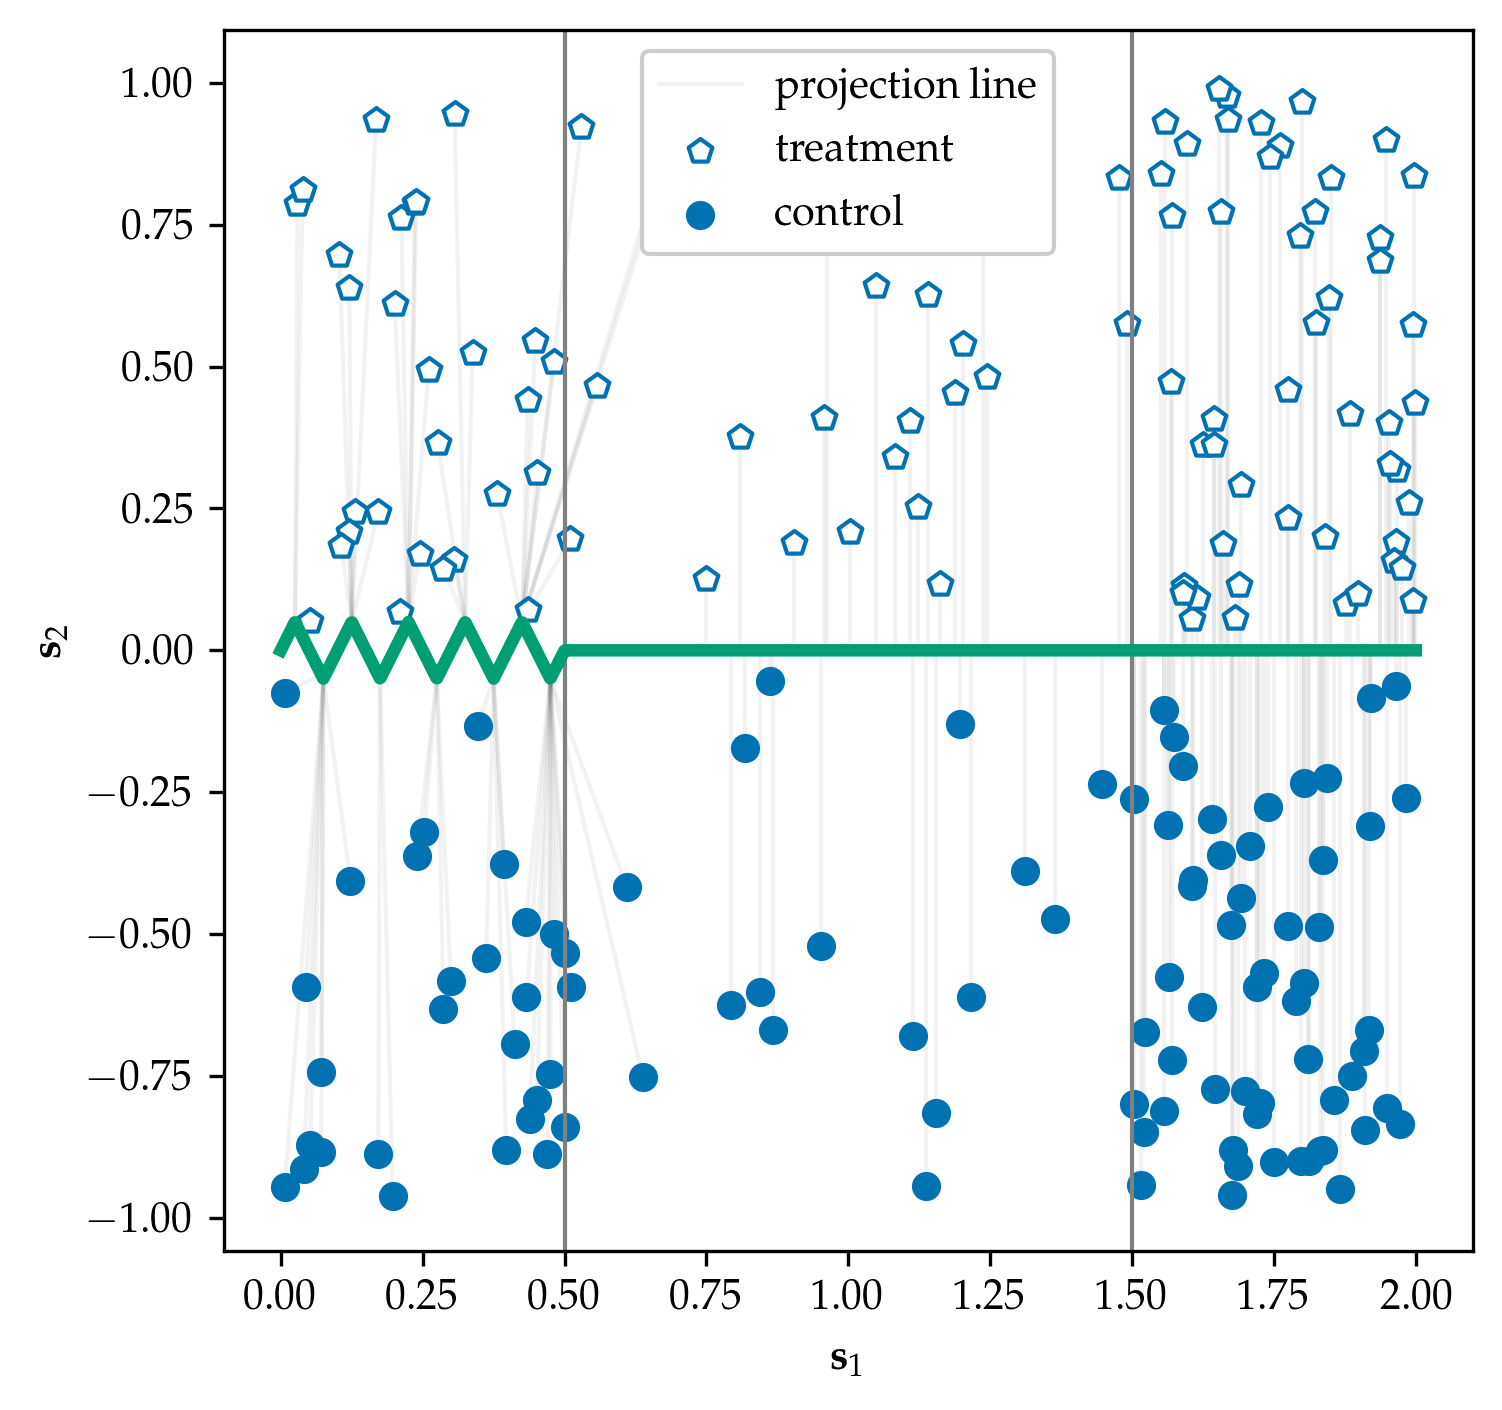

In [11]:
function plot_setup()
    plt.axvline(0.5, color="grey", linewidth=1)
    plt.axvline(1.5, color="grey", linewidth=1)
    for itreat in 1:wb_ntreat
        # obtain coordinates for treatment point
        x,y = wbX_treat[:,itreat]
        # projection onto border (as distance along border)
        proj_point = nearestPoints(wb_border, Point(x,y))[1]
        # get coordinates from point
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        if itreat==1
            label="projection line"
        else
            label=""
        end
        plt.plot([x, proj_x], [y, proj_y], 
                color="black", alpha=0.05, linewidth=1,
                label=label,
                zorder=-10)
    end
    for ictrol in 1:wb_nctrol
        # obtain coordinates for treatment point
        x,y = wbX_ctrol[:,ictrol]
        proj_point = nearestPoints(wb_border, Point(x,y))[1]
        # get coordinates from point
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        plt.plot([x, proj_x], [y, proj_y], 
                color="black", alpha=0.05, linewidth=1,
                zorder=-10)
    end
    
    plt.scatter(wbX_treat[1,:],wbX_treat[2,:], color="white", edgecolor="#0072B2", marker="p", label="treatment")
    plt.scatter(wbX_ctrol[1,:],wbX_ctrol[2,:], color="#0072B2", label="control")
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.plot(border_x, border_y, linewidth=3, color="#009E73")
    plt.grid(false)
    plt.title("Data locations")
    plt.legend(loc="best", framealpha=1.0)
    plt.xlabel(L"$\mathbf{s}_1$")
    plt.ylabel(L"$\mathbf{s}_2$")
end
plot_setup()
if do_savefig
    plt.title("")
    plt.savefig(joinpath(figures_dir, "wiggly_boundaries_setup.png"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "wiggly_boundaries_setup.pdf"), bbox_inches="tight")
end
;

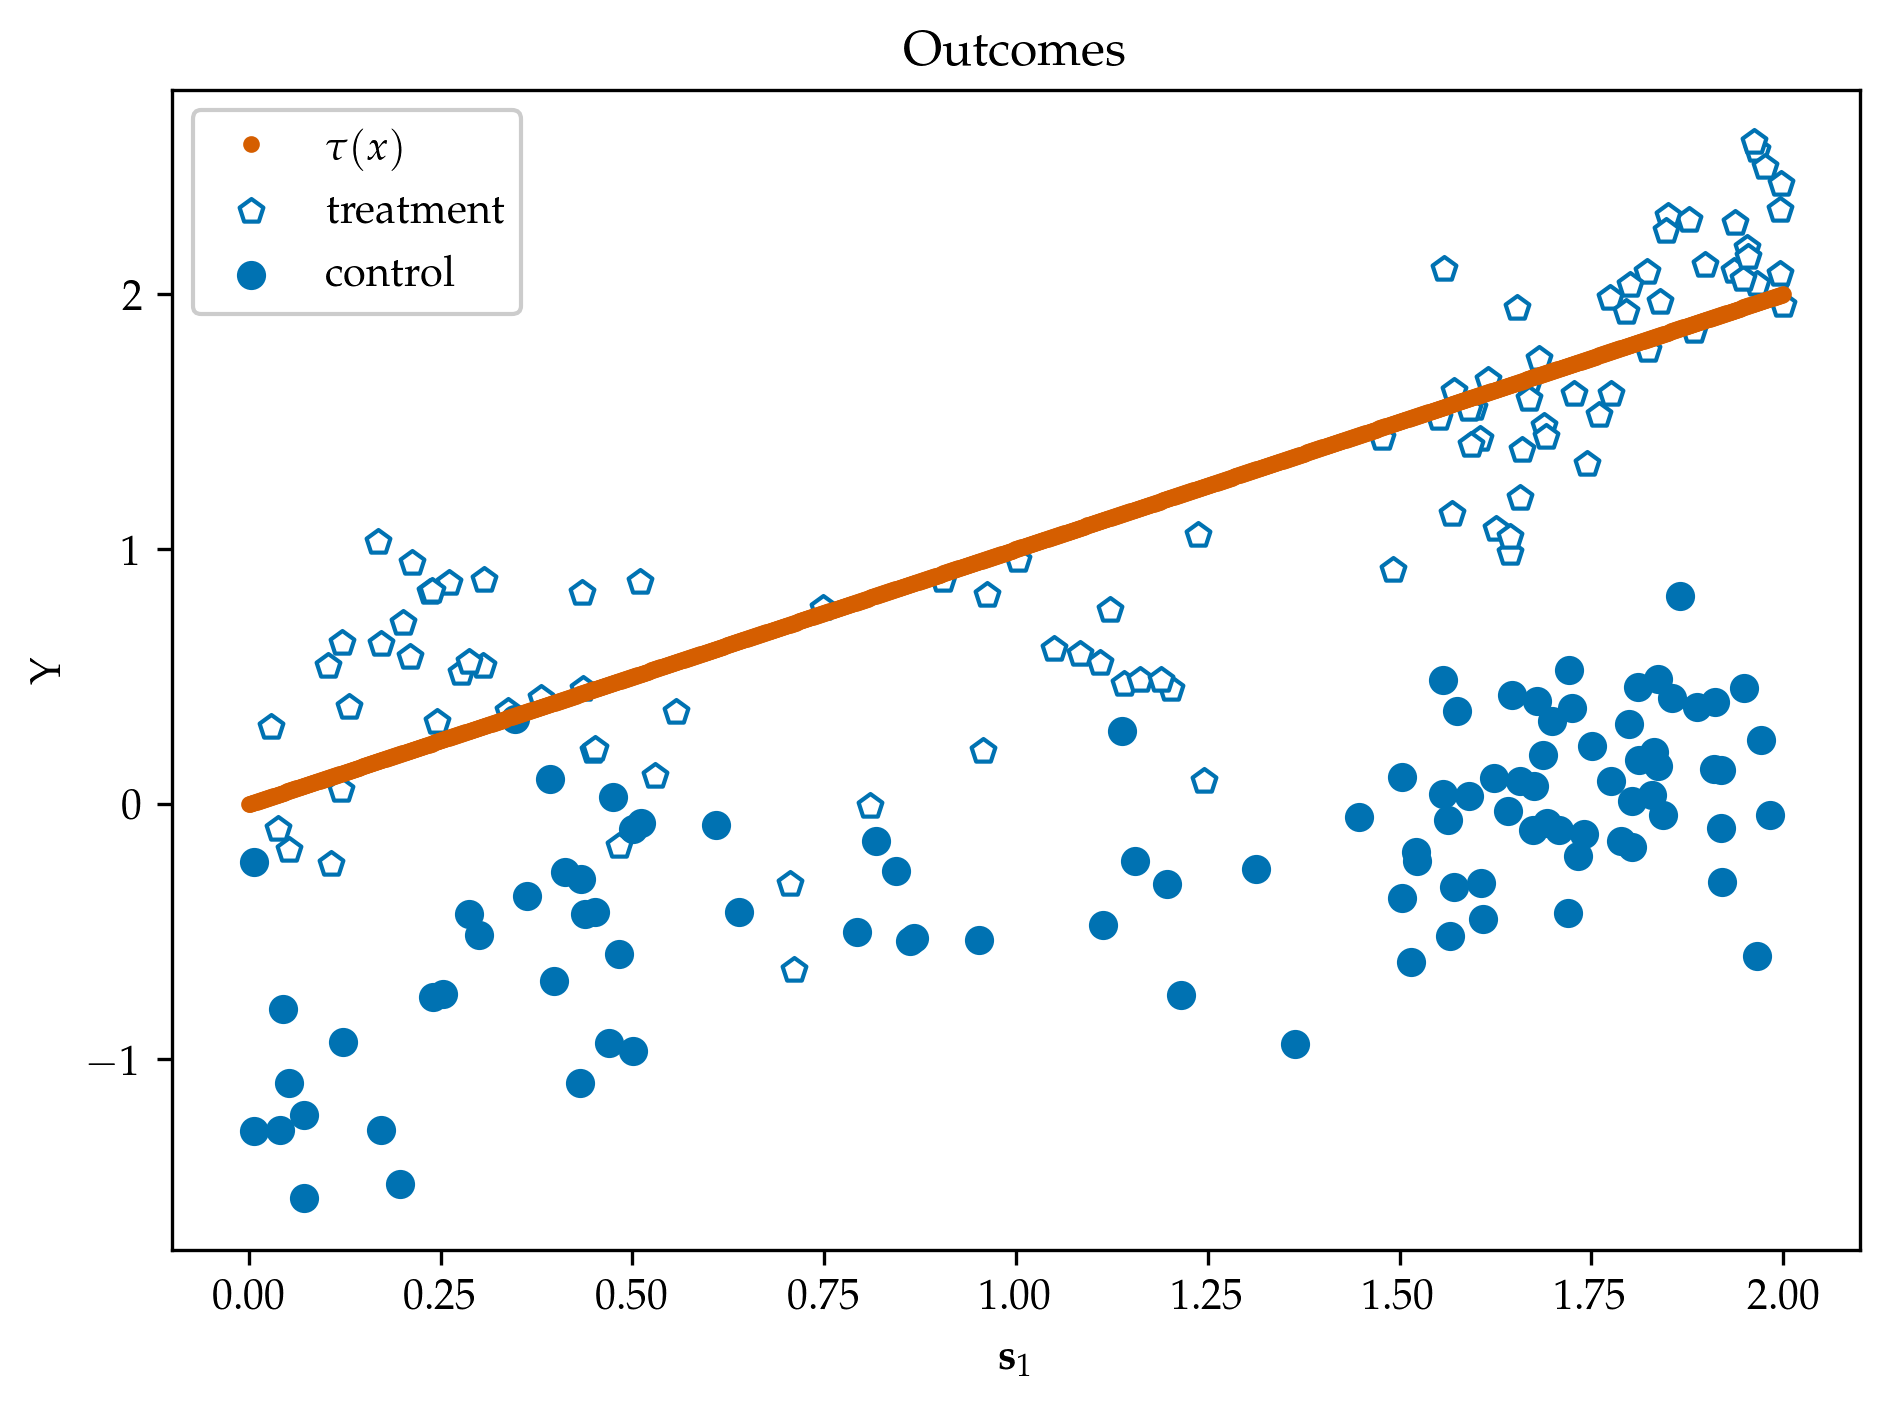

In [12]:
function plot_outcomes()
    plt.scatter(vec(sim.X_treat[1,:]), wb_Ytreat, 
                color="white", 
                edgecolor="#0072B2", 
                marker="p", 
                label="treatment")
    plt.scatter(vec(sim.X_ctrol[1,:]), wb_Yctrol, 
                color="#0072B2", 
                label="control")
    plt.xlabel(L"\mathbf{s}_1")
    plt.ylabel("Y")
    xx = range(0,stop=2.0,length=1000)
    plt.plot(xx, wb_τx.(xx), ".", color="#D55E00", label=L"\tau(x)")
    plt.legend(loc="best", framealpha=1.0)
    plt.title("Outcomes")
end
plot_outcomes()
;

A quick histogram to check that the density is what we say it is:

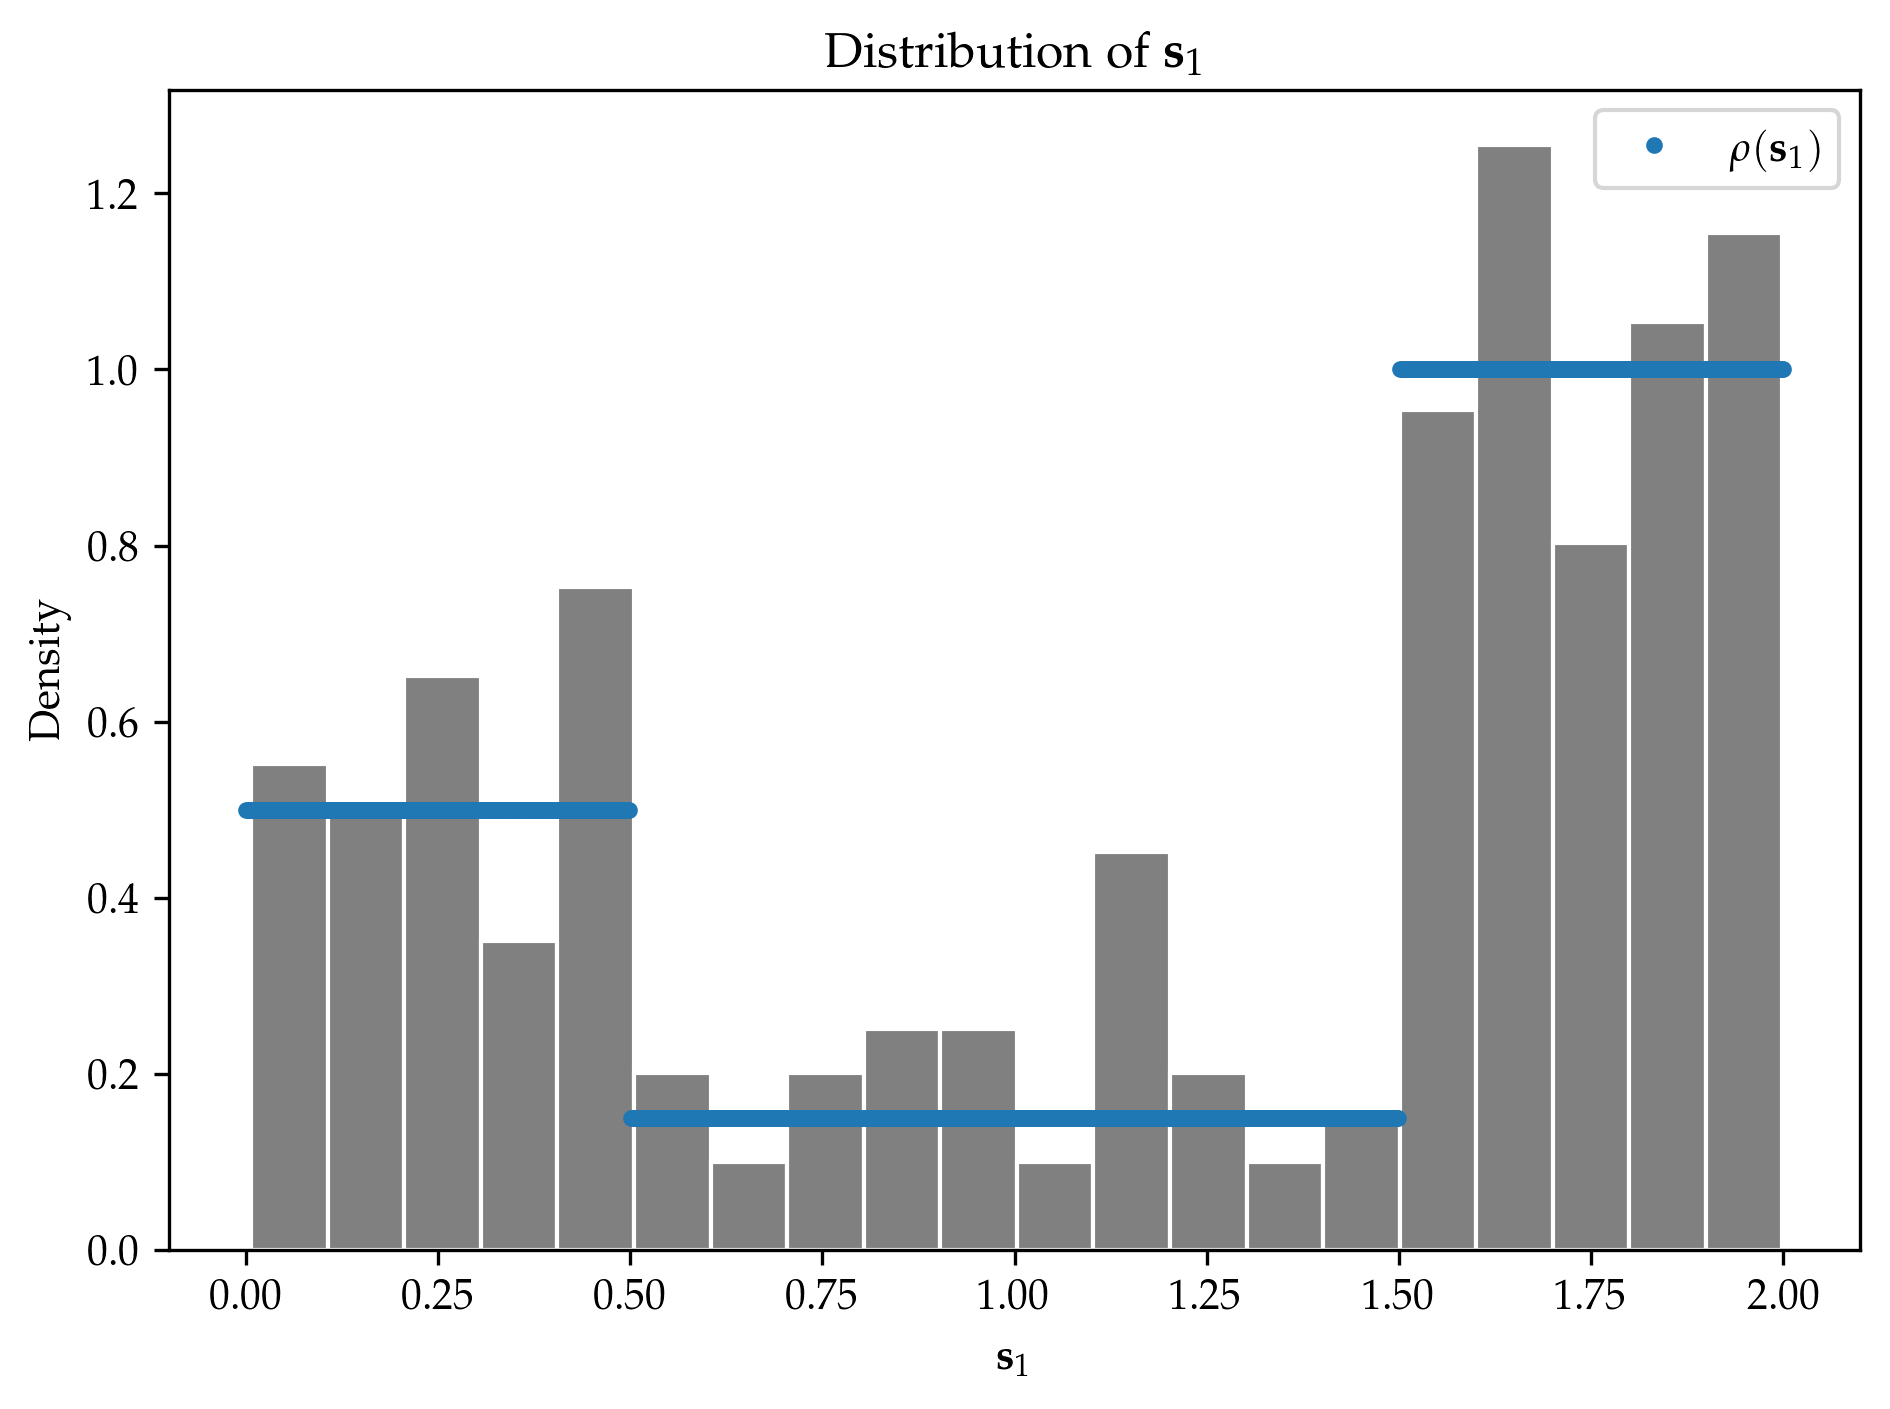

In [13]:
function plot_x1()
    plt.title(L"Distribution of $\mathbf{s}_1$")
    plt.hist(vec([sim.X_treat sim.X_ctrol][1,:]), 
                   color="grey", 
                   edgecolor="white",
                   bins=20, 
                   density=true)
    xx=range(0,stop=2.0,length=1000)
    plt.plot(xx,wb_density.(xx) ./ 2, ".", label=L"$\rho(\mathbf{s}_1)$")
    plt.xlabel(L"$\mathbf{s}_1$")
    plt.ylabel("Density")
    plt.legend(loc="best")
end
plot_x1()
;

Now, what are the actual simulations? I'm not actually going to touch the locations or the outcomes. The only change I am going to make is to the boundary. I am going to progressively increase the wiggliness of the left side of the boundary. The boundary grid points are always going to be equidistant, with $\Delta x = 0.01$ between points. That means that as the wiggliness increases, so does the number of boundary grid points.

The function `wb_estimators` below obtains the boundary grid points, generates GP predictions at those points from the treatment and control fitted GPs that were pre-computed, computes the posterior mean and variance of the difference at the boundary points, and then applies the three estimators of interest:

1. unweighted
2. inverse-variance weighted
3. density-weighted

We then show the estimate and credible intervals as a function of the number of wiggles between $x=0$ and $x=0.5$.

# Fit GPs

**The fitting kernel includes a constant component to capture the mean of each surface.**

In [14]:
k_const = Const(log(100.0)) + wb_kern
wb_const_T = GPE(wbX_treat, collect(wb_Ytreat),  
                  MeanConst(mean(wb_Ytreat)), 
                  k_const, log(√wb_σy2))
wb_const_C = GPE(wbX_ctrol, collect(wb_Yctrol), 
                  MeanConst(mean(wb_Yctrol)), 
                  k_const, log(√wb_σy2))

wb_fit_treat = wb_const_T
wb_fit_ctrol = wb_const_C
;

# Weight functions

# Estimators

In [15]:
function wb_estimators(gpT::GPE, gpC::GPE, nwiggles::Int)
    border = border_line(nwiggles, wb_A)
    nb = 1000
    maxdist = Inf
    gridspace = 0.01
    
    Xb = GeoRDD.sentinels(border, nb)
    
    density = (s1, s2) -> wb_density(s1)

    μpost, Σpost = GeoRDD.cliff_face(gpT, gpC, Xb)
    
    unweighted = GeoRDD.unweighted_mean(μpost, Σpost)
    
    invvariance = GeoRDD.inverse_variance(μpost, Σpost)
    
    stnl_ρ = wb_density.(Xb[1,:])
    densityw = GeoRDD.weighted_mean(μpost, Σpost, stnl_ρ)
    
    projτ = GeoRDD.proj_estimator(gpT, gpC, border, maxdist)
    
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -wb_A/2], # top left
         [2.0, -wb_A/2], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, wb_A/2],  # bottom left
         [2.0, wb_A/2],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
    region = LibGEOS.union(region_C, region_T)
    
    inf_proj_τ = GeoRDD.infinite_proj_estim(gpT, gpC, border, region, 
                                                   maxdist, gridspace)
    
    infρ_proj_τ = GeoRDD.infinite_proj_estim(gpT, gpC, border, region, 
                                                    maxdist, gridspace; density=density)
    
    return (unweighted, invvariance, densityw, projτ, inf_proj_τ, infρ_proj_τ)
end
;

In [16]:
# wb_estimators(wb_fit_treat, wb_fit_ctrol, 3);
@time wb_estimators(wb_fit_treat, wb_fit_ctrol, 3);

 27.747007 seconds (22.33 M allocations: 1.243 GiB, 4.56% gc time)


## Average estimate over multiple simulations

In [17]:
function avg_estimator(sim::SimulationSetting, gpT::GPE, gpC::GPE, nwiggles::Int, nsim::Int)
    border = border_line(nwiggles, wb_A)
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -wb_A/2], # top left
         [2.0, -wb_A/2], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, wb_A/2],  # bottom left
         [2.0, wb_A/2],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
         
    region = LibGEOS.union(region_C, region_T)
    nb = 1000
    maxdist = Inf
    gridspace = 0.01
    estimators = (:unif, :invvar, :rho, :proj, :geo, :pop)
    density = (s1, s2) -> wb_density(s1)
    weight_functions = Dict(:unif   => () -> GeoRDD.weights_unif(gpT, gpC, nb, border), 
                            :invvar => () -> GeoRDD.weights_invvar(gpT, gpC, nb, border),
                            :proj   => () -> GeoRDD.weights_proj(gpT, gpC, border, maxdist),
                            :geo    => () -> GeoRDD.weights_geo(gpT, gpC, border, region, maxdist, gridspace),
                            :pop    => () -> GeoRDD.weights_pop(gpT, gpC, density, border, region, maxdist, gridspace),
                            :rho    => () -> GeoRDD.weights_rho(gpT, gpC, density, nb, border), 
                            )
    
    weights_units = Dict{Symbol,Vector}()
    τ_vectors = Dict{Symbol, Vector{Float64}}()
    for est_symbol in estimators
        _, _, w = weight_functions[est_symbol]()
        weights_units[est_symbol] = w
        τ_vectors[est_symbol] = Float64[]
    end
    
    for isim in 1:nsim
        Y, Ytreat, Yctrol = rand(sim)
        
        for est_symbol in estimators
            τ = sum(Y .* weights_units[est_symbol])
            push!(τ_vectors[est_symbol], τ)
        end
    end
        
    
    return [mean(τ_vectors[est]) for est in estimators]
end
;

In [18]:
Random.seed!(1)
@time avg_estimator(sim, wb_fit_treat, wb_fit_ctrol, 2, 10)

  9.452862 seconds (4.83 M allocations: 291.968 MiB, 1.67% gc time)


6-element Array{Float64,1}:
 1.093017698256653
 1.1156201734972542
 1.2234915278582825
 1.2647417859845849
 1.132517921987006
 1.2840431285427183

## Estimand

In [19]:
function wb_estimands(gpT::GPE, gpC::GPE, nwiggles::Int)
    border = border_line(nwiggles, wb_A)
    nb = 1000
    maxdist = Inf
    gridspace = 0.01
    Xb = GeoRDD.sentinels(border, nb)
    
    _, Σpost = GeoRDD.cliff_face(gpT, gpC, Xb)
    
    density = (s1, s2) -> wb_density(s1)
    true_τ = Vector{Float64}(undef, nb)
    for i in 1:nb
        s1, s2 = Xb[:,i]
        true_τ[i] = wb_τx(s1)
    end
    
    unweighted = GeoRDD.unweighted_mean(true_τ, Σpost)
    
    invvariance = GeoRDD.inverse_variance(true_τ, Σpost)
    
    stnl_ρ = wb_density.(Xb[1,:])
    densityw = GeoRDD.weighted_mean(true_τ, Σpost, stnl_ρ)
    
    # proj_estimator
    Xb_treat = GeoRDD.projection_points(gpT, border, maxdist)
    Xb_ctrol = GeoRDD.projection_points(gpC, border, maxdist)
    Xb_projected = [Xb_treat Xb_ctrol]
    n_proj = size(Xb_projected, 2)
    true_τ_proj = Vector{Float64}(undef, n_proj)
    for i in 1:n_proj
        s1, s2 = Xb_projected[:,i]
        true_τ_proj[i] = wb_τx(s1)
    end
    
    _, Σpost = GeoRDD.cliff_face(gpT, gpC, Xb_projected)
    projτ = GeoRDD.unweighted_mean(true_τ_proj, Σpost)
    
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -wb_A/2], # top left
         [2.0, -wb_A/2], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, wb_A/2],  # bottom left
         [2.0, wb_A/2],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
    region = LibGEOS.union(region_C, region_T)
    
    # Infinite-population projection estimators
    Xb_projected, weights = GeoRDD.infinite_proj_sentinels(
            gpT, gpC, border, region, maxdist, gridspace)
    n_proj = size(Xb_projected, 2)
    true_τ_proj = Vector{Float64}(undef, n_proj)
    for i in 1:n_proj
        s1, s2 = Xb_projected[:,i]
        true_τ_proj[i] = wb_τx(s1)
    end
    _, Σpost = GeoRDD.cliff_face(gpT, gpC, Xb_projected)
    inf_proj_τ = GeoRDD.weighted_mean(true_τ_proj, Σpost, weights)
    
    Xb_projected, weights = GeoRDD.infinite_proj_sentinels(
            gpT, gpC, border, region, maxdist, gridspace; density=density)
    infρ_proj_τ = GeoRDD.weighted_mean(true_τ_proj, Σpost, weights)
    return (unweighted, invvariance, densityw, projτ, inf_proj_τ, infρ_proj_τ)
end

wb_estimands (generic function with 1 method)

In [20]:
# compute estimates
wb_nwiggles_arr = [0, 1, 2, 3, 5, 10, 20, 40, 80, 160, 320, 640, 1000]
;

In [21]:
wb_estimators(wb_fit_treat, wb_fit_ctrol, 3);
@time wb_estimates = [wb_estimators(wb_fit_treat, wb_fit_ctrol, nw) for nw in wb_nwiggles_arr]
;

301.525820 seconds (29.47 M allocations: 2.297 GiB, 0.84% gc time)


In [22]:
# compute estimates
Random.seed!(1)
@time wb_mean_estimates = [avg_estimator(sim, wb_fit_treat, wb_fit_ctrol, nw, 10000) 
                           for nw in wb_nwiggles_arr]
;

372.650108 seconds (70.32 M allocations: 4.264 GiB, 1.08% gc time)


In [23]:
# compute estimands
@time estimands = [wb_estimands(wb_fit_treat, wb_fit_ctrol, n) for n in wb_nwiggles_arr]
;

340.389159 seconds (27.42 M allocations: 2.086 GiB, 0.53% gc time)


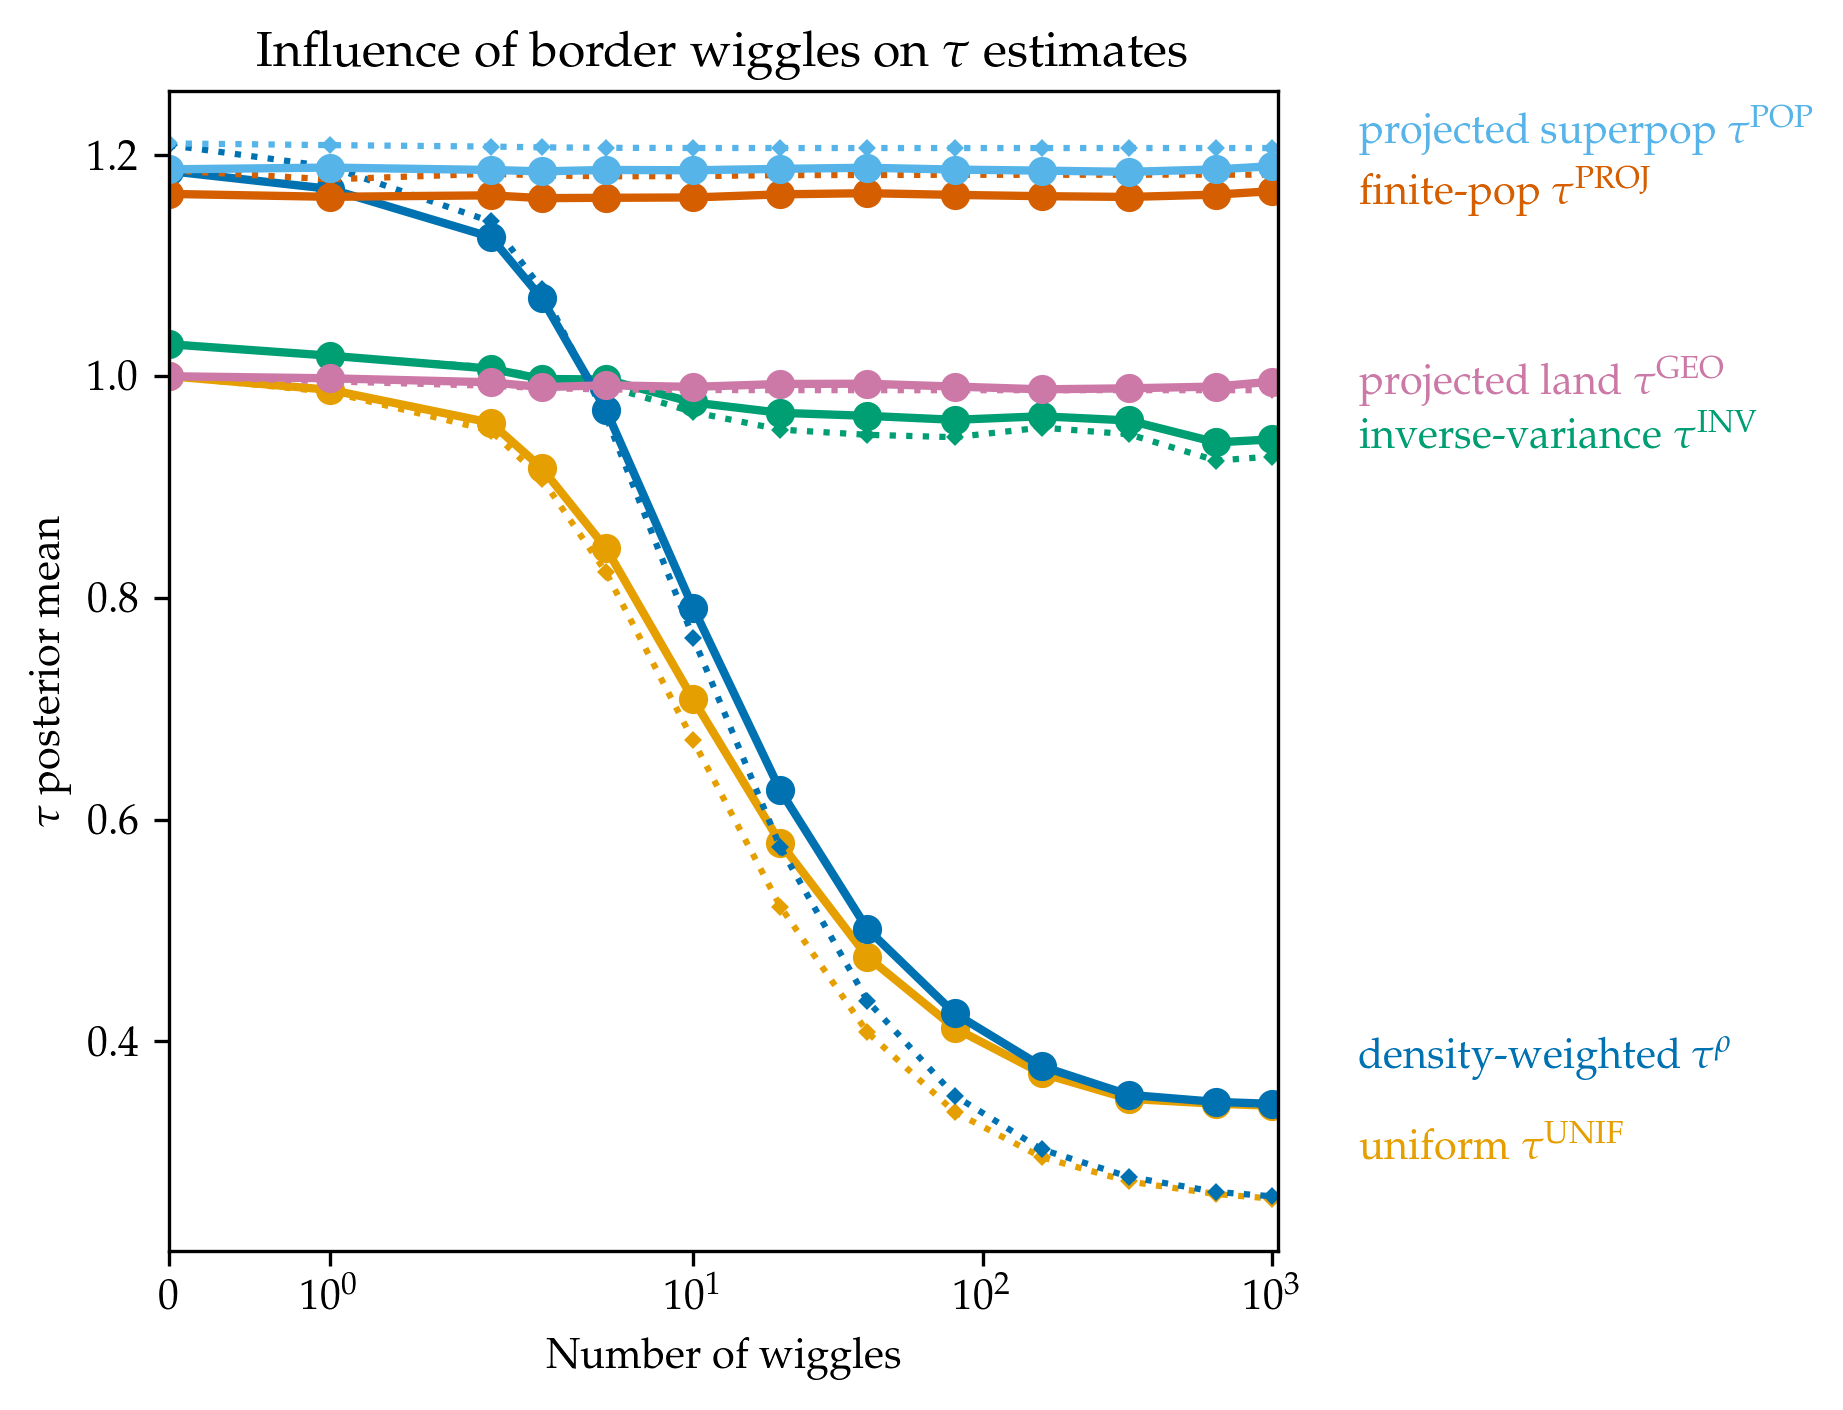

In [24]:
function plot_mean_estimates(label_adjust::Float64)
    plt.title(L"Influence of border wiggles on $\tau$ estimates")
    capsize=3
    cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                  "#0072B2", "#D55E00", "#CC79A7"]
    for (iest, label, color, hatch, hatch_dens, label_shift) in zip(
            1:6,
             [L"uniform $\tau^{\mathrm{UNIF}}$",
              L"inverse-variance $\tau^{\mathrm{INV}}$",
              L"density-weighted $\tau^{\rho}$",
              L"finite-pop $\tau^{\mathrm{PROJ}}$",
              L"projected land $\tau^{\mathrm{GEO}}$",
              L"projected superpop $\tau^{\mathrm{POP}}$",
              ],
             cbbPalette[[2,4,6,7,8,3]],
#              [ '/' | '\\' | '|' | '-' | '+' | 'x' | 'o' | 'O' | '.' | '*' ], 
             ["/", "|", "|", "\\", "\\", "/"],
             [7,6,5,7,6,5],
             [-1.0,
              0.0,
              1.0,
              0.0,
              0.0,
              0.8]
             )
        y = [est[iest] for est in wb_mean_estimates] # [mean(wbe[iest]) for wbe in wb_estimates]
        y_std = [std(wbe[iest]) for wbe in wb_estimates]
        plt.plot(wb_nwiggles_arr, 
            [mean(wbe[iest]) for wbe in estimands], 
            color=color,
            linestyle=":",
            marker="D",
            markersize=2,
            )
            
        plt.plot(wb_nwiggles_arr, y, 
                 color=color,
                 linewidth=2,
                 marker="o",
                 label=label,
                 )

        y_label = y[end]
        if iest == 1
            y_label -= 0.2
        end
        ax = plt.gca()
        plt.draw()
        
        label_x = wb_nwiggles_arr[end] * 2
        label_y = y[end] + label_shift * label_adjust
        t = plt.text(x=label_x, y=label_y, s=label,
                     color=color,
#                      rotation=45,
                     verticalalignment="center",
                     horizontalalignment="left",
                     bbox=Dict("facecolor" => "none",
                               "edgecolor" => "none",
                               "pad" => 1.0,
                               )
                     )
    end
    plt.xlabel("Number of wiggles")
    plt.ylabel(L"$\tau$ posterior mean")
    plt.gca().set_xscale("symlog")
    plt.xlim(0)
end
plot_mean_estimates(0.04)
;

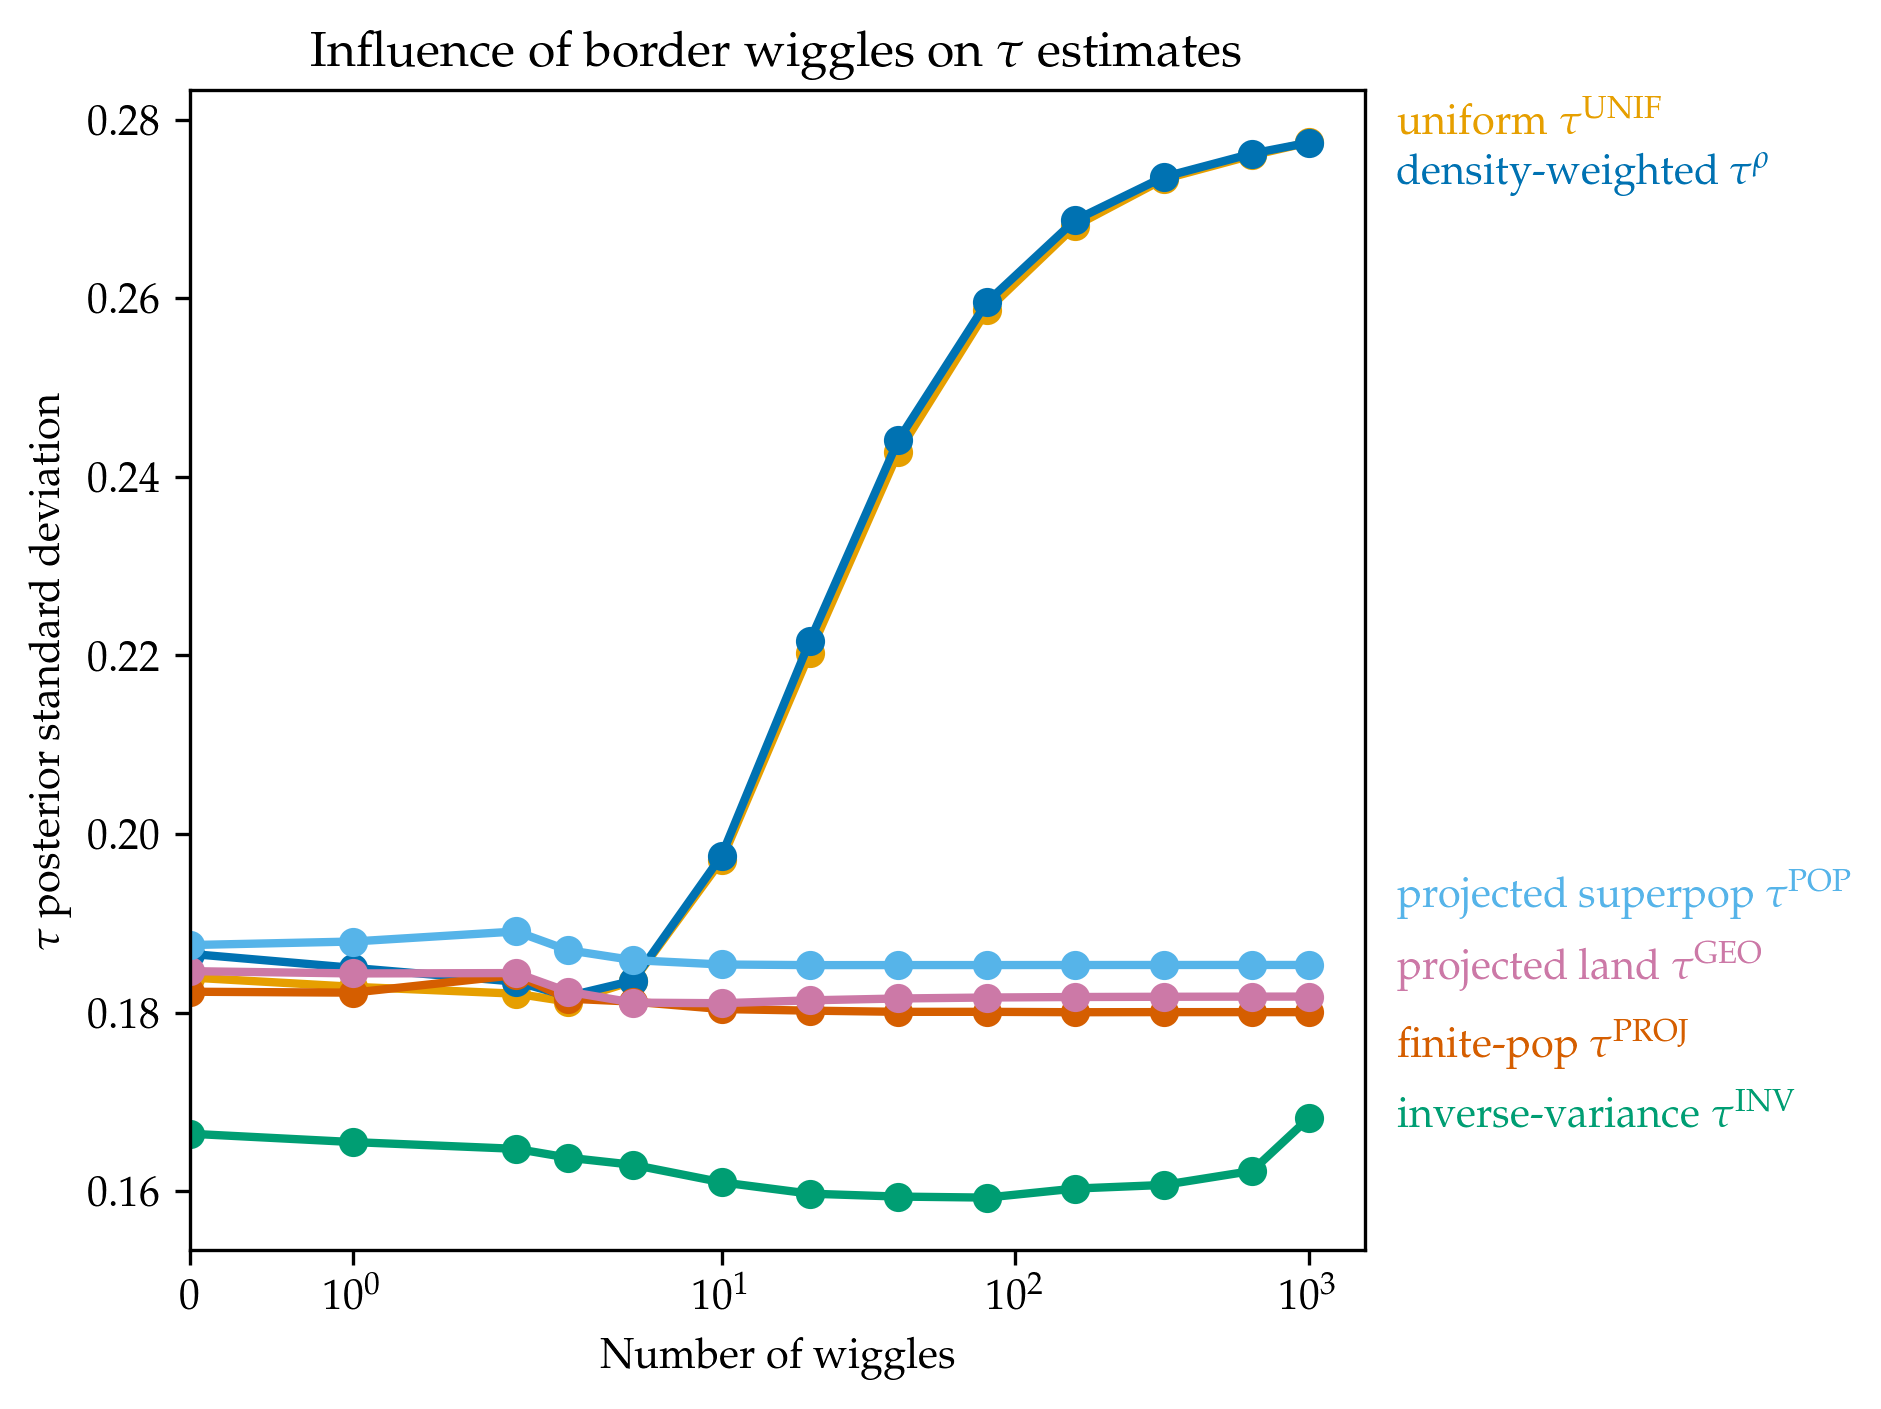

In [25]:
function plot_se_estimates(label_adjust::Float64)
    plt.title(L"Influence of border wiggles on $\tau$ estimates")
    capsize=3
    cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                  "#0072B2", "#D55E00", "#CC79A7"]
    for (iest, label, color, hatch, hatch_dens, label_shift) in zip(
            1:6,
             [L"uniform $\tau^{\mathrm{UNIF}}$",
              L"inverse-variance $\tau^{\mathrm{INV}}$",
              L"density-weighted $\tau^{\rho}$",
              L"finite-pop $\tau^{\mathrm{PROJ}}$",
              L"projected land $\tau^{\mathrm{GEO}}$",
              L"projected superpop $\tau^{\mathrm{POP}}$",
              ],
             cbbPalette[[2,4,6,7,8,3]],
#              [ '/' | '\\' | '|' | '-' | '+' | 'x' | 'o' | 'O' | '.' | '*' ], 
             ["/", "|", "|", "\\", "\\", "/"],
             [7,6,5,7,6,5],
             [2.0,
              0.0,
              -3.5,
              -3.5,
              3.5,
              8.0]
             )
        y_std = [std(wbe[iest]) for wbe in wb_estimates]
            
        plt.plot(wb_nwiggles_arr, y_std, 
                 color=color,
                 linewidth=2,
                 marker="o",
                 label=label,
                 )

        label_x = wb_nwiggles_arr[end] * 2
        label_y = y_std[end] + label_shift * label_adjust
        plt.text(x=label_x, y=label_y, s=label,
                 color=color,
#                  rotation=45,
                 verticalalignment="center",
                 horizontalalignment="left",
                 bbox=Dict("facecolor" => "none",
                           "edgecolor" => "none",
                           "pad" => 1.0,
                           )
                 )
    end
    plt.xlabel("Number of wiggles")
    plt.ylabel(L"$\tau$ posterior standard deviation")
    plt.gca().set_xscale("symlog")
    plt.xlim(0)
end
plot_se_estimates(0.001)
;

First a quick table to remind us of the simulation setup.

|    Variable        | Left $x< 0.5$    | Middle $0.5 \ge x < 1.5$ | Right $1.5 \ge x$ |
|-------------------:|------------------|--------------------------|-------------------|
|         **Border** | wiggly           | straight                 | straight          |
|        **Density** | low $\rho=1.0$   | very low $\rho=0.1$      | high $\rho=2.8$   |
| $\mathbf{\tau(x)}$ | small            | medium                   | large             |

In the plot, we see the effect very clearly: when there is only one wiggle, the inverse-variance and density-weighted estimates are in pretty close agreement, close to the true value of $\tau$. The unweighted estimator gives more weight to the left (less dense) region, which also has lower $\tau(x)$, leading to a lower $\hat\tau$ estimate. But as more wiggles get added, and hence more grid points are added to the left (wiggly) region, the unweighted and density-weighted estimates systematically give more weight to the left region, and hence the estimates go down. Meanwhile, the inverse-variance estimator, because it takes the covariance structure into account, is not susceptible to this issue.

Obviously, the extremely wiggly border is unrealistic in most situations, but this does highlight an undesirable feature of the density-weighted estimator. Another manifestation of this issue is that the estimate changes if the gridpoints aren't evenly spaced.

## 2x1 plot

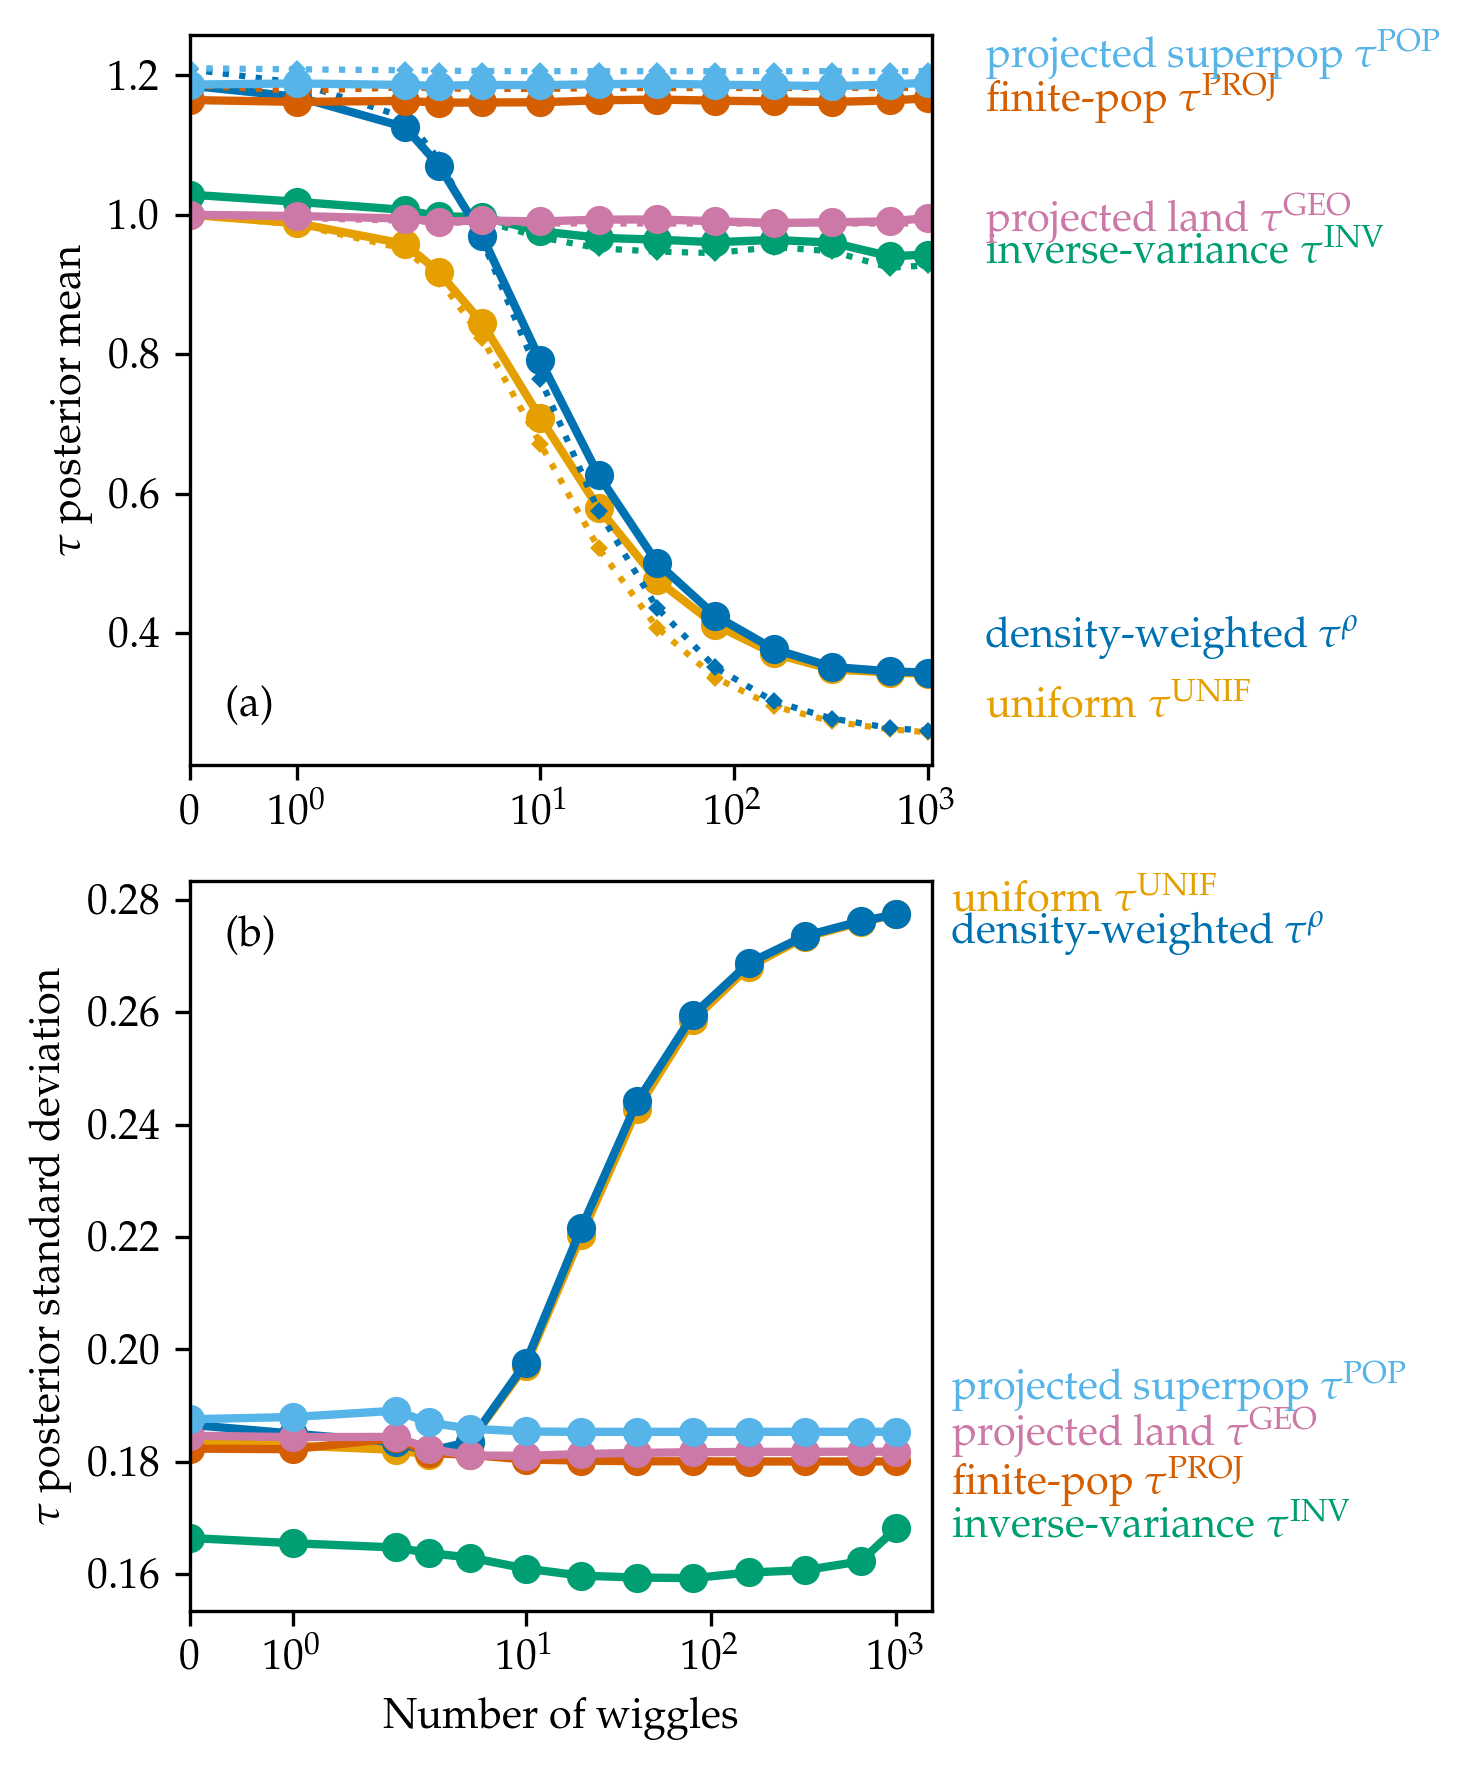

In [26]:
fig=plt.figure()
fig.set_size_inches(5.0,6.0)
plt.subplot(2,1,1)
plot_mean_estimates(0.05)
plt.xlabel("")
plt.title("")
plt.text(0.05, 0.05, "(a)",
     horizontalalignment="left",
     verticalalignment="bottom",
     transform = plt.gca().transAxes)
plt.subplot(2,1,2)
plot_se_estimates(0.001)
plt.title("")
plt.text(0.05, 0.95, "(b)",
     horizontalalignment="left",
     verticalalignment="top",
     transform = plt.gca().transAxes)
if do_savefig
    plt.savefig(joinpath(figures_dir, "wiggly_boundaries_posteriors.png"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "wiggly_boundaries_posteriors.pdf"), bbox_inches="tight")
end
;

# Weights at units

In [27]:
function plot_unit_weights(X::Matrix, weight::Vector; scale=500)
    @assert size(X,2) == length(weight)
    pos = weight .> 0
    neg = .!pos
#     plt.scatter(X[1,:], X[2,:], s=5, color="None", linewidth=0.5, edgecolor="black", marker="o")
    plt.scatter(X[1,pos], X[2,pos], scale.*abs.(weight[pos]), color="#0072B2", edgecolor="none", marker="o")
    plt.scatter(X[1,neg], X[2,neg], scale.*abs.(weight[neg]), color="#E69F00", edgecolor="none", marker="o")
end
function plot_unit_weights(gpT::GPE, gpC::GPE, Xb::Matrix, weights_b::Vector; scale=500)
    for (gp, sign) in ( (gpT, 1), (gpC, -1) )
        w = GeoRDD.weight_at_units(gp, Xb, weights_b) .* sign
        # plt.scatter(gp.x[1,:], gp.x[2,:], 1.0, color="black", edgecolor="none", marker=",", label="treatment")
        plot_unit_weights(gp.x, w; scale=scale)
    end;
end

function plot_border_weights(border::GeoRDD.BorderType, Xb::Matrix, weights_b::Vector; rug=false, x_is_s1=true)
    nb = size(Xb, 2)
    local xx
    if x_is_s1
        xx = Xb[1,:]
    else
        xx = collect(1.0:nb)
    end
    if rug
        xorder = sortperm(xx)
        sorted_xx = view(xx, xorder)
        sorted_w = view(weights_b ./ sum(weights_b), xorder)
        while minimum(diff(sorted_xx)) < 0.005            
            imerge = argmin(diff(sorted_xx))
            w_merge_a = sorted_w[imerge]
            w_merge_b = sorted_w[imerge+1]
            x_merge_a = sorted_xx[imerge]
            x_merge_b = sorted_xx[imerge+1]
            # weighted average
            new_x = (w_merge_a*x_merge_a + w_merge_b*x_merge_b) / (w_merge_a+w_merge_b)
            new_w = w_merge_a + w_merge_b
            sorted_xx[imerge] = new_x
            sorted_w[imerge] = new_w
            sorted_w[imerge+1] = 0.0
            
            n_xx = length(sorted_xx)
            sorted_xx = view(sorted_xx, 1:n_xx .!= (imerge+1))
            sorted_w = view(sorted_w, 1:n_xx .!= (imerge+1))
        end
        @assert sum(sorted_w) ≈ 1.0
        for i in 1:length(sorted_xx)
            plt.plot([sorted_xx[i], sorted_xx[i]], [0.0, sorted_w[i]], color="#0072B2")
        end
    else
        diff_x = diff(xx)
        diff_x_plus = [diff_x; diff_x[end]]
        y_weights = weights_b./diff_x_plus./sum(weights_b)
        plt.plot(xx, y_weights, color="#0072B2")
    end
end
;

In [28]:
nwiggles = 3
border = border_line(nwiggles, wb_A)
;

In [29]:
function plot_border(border)
    border_points = [interpolate(border,q) for q in range(0,stop=geomLength(wb_border),length=1000)]
    border_coords = [GeoInterface.coordinates(p) for p in border_points]
    border_x = [p[1] for p in border_coords]
    border_y = [p[2] for p in border_coords]
    plt.plot(border_x, border_y, linewidth=3, color="#009E73", zorder=-10);
end
;

## projected 1D RDD

In [30]:
module Projected1dRDD
    using RCall
    using LibGEOS: LineString, MultiLineString, Point, distance
    using LinearAlgebra: dot

    function triangular_kernel(x1,x2,bw)
        max(1-abs(x1-x2)/bw, 0.0)
    end

    function IR_bandwidth(x::Vector, y::Vector, polydeg::Int)
        R"library(rdrobust)"
        bws_R = R"""rdbwselect($y,$x,p=$polydeg,bwselect="mserd")$bws"""
        bws = rcopy(bws_R)
        bandwidth = bws[1]
        return bandwidth
    end

    function llr(x::Vector, y::Vector, polydeg::Int, xfit::Float64, bandwidth::Float64)
        n = length(y)
        X = Matrix{Float64}(undef, n, polydeg+1)
        for deg in 0:polydeg
            X[:,deg+1] = x.^deg
        end
        w = triangular_kernel.(x, xfit, bandwidth)
        Xfit = [xfit^deg for deg in 0:polydeg]
        XtWX = X' * (w .* X)
        weights = (w .* X) * (XtWX \ Xfit)
        mu_fit = dot(weights, y)
        return weights, mu_fit
    end

    struct LLR_RDD_Output
        x::Vector
        y::Vector
        polydeg::Int
        bandwidth::Float64
        τhat::Float64
        weights::Vector
    end

    function llr_rdd(x::Vector, y::Vector, polydeg::Int)
        n = length(y)
        bandwidth = IR_bandwidth(x, y, polydeg)
        treat = x .> 0
        ctrol = .!treat
        w_T, mu_T = llr(x[treat], y[treat], polydeg, 0.0, bandwidth)
        w_C, mu_C = llr(x[ctrol], y[ctrol], polydeg, 0.0, bandwidth)
        τhat = mu_T - mu_C
        weights = Vector{Float64}(undef, n)
        weights[treat] = w_T
        weights[ctrol] = -w_C
        return LLR_RDD_Output(
            x, y, polydeg,
            bandwidth,
            τhat,
            weights
            )
    end
    function llr_rdd(X_T::Matrix, X_C::Matrix, y_T::Vector, y_C::Vector, border::Union{LineString, MultiLineString}, polydeg::Int)
        distance_T = [distance(border, Point(X_T[:,i]))
                      for i in 1:size(X_T, 2)
                      ]
        distance_C = [distance(border, Point(X_C[:,i]))
                      for i in 1:size(X_C, 2)
                      ]
        x_proj = vcat(distance_T, -distance_C)
        y_proj = vcat(y_T, y_C)
        return llr_rdd(x_proj, y_proj, polydeg)
    end
end

Main.Projected1dRDD

In [31]:
llr_out = let
    gpT = wb_fit_treat
    gpC = wb_fit_ctrol
    X_T = gpT.x
    X_C = gpC.x
    y_T = gpT.y
    y_C = gpC.y

    polydeg = 1 # linear
    llr_out = Projected1dRDD.llr_rdd(X_T, X_C, y_T, y_C, border, polydeg)
end
llr_out.τhat

1.6106578586756204

## uniform

In [32]:
function plot_wunits_unif(gpT::GPE, gpC::GPE; on_border=false)
    nb = 100
    Xb, w_border, w_units = GeoRDD.weights_unif(gpT, gpC, nb, border)
    if on_border
        plot_border_weights(border, Xb, w_border; rug=true, x_is_s1=true)
    else
        plot_border(border)
        plot_unit_weights(gpT, gpC, Xb, w_border; scale=500)
    end
end

plot_wunits_unif (generic function with 1 method)

## inverse variance

In [33]:
function plot_wunits_inv(gpT::GPE, gpC::GPE; on_border=false)
    nb = 100
    Xb, w_border, w_units = GeoRDD.weights_invvar(gpT, gpC, nb, border)
    if on_border
        plot_border_weights(border, Xb, w_border; rug=true, x_is_s1=true)
    else
        plot_border(border)
        plot_unit_weights(gpT, gpC, Xb, w_border; scale=500)
    end
end

plot_wunits_inv (generic function with 1 method)

## finite population projected

In [34]:
function plot_wunits_proj(gpT::GPE, gpC::GPE; on_border=false)
    maxdist = Inf
    Xb, w_border, w_units = GeoRDD.weights_proj(gpT, gpC, border, maxdist)
    if on_border
        plot_border_weights(border, Xb, w_border; rug=true, x_is_s1=true)
    else
        plot_border(border)
        plot_unit_weights(gpT, gpC, Xb, w_border; scale=500)
    end
end

plot_wunits_proj (generic function with 1 method)

## Infinite-population GEO

In [35]:
function plot_wunits_geo(gpT::GPE, gpC::GPE; on_border=false)
    maxdist = Inf
    gridspace = 0.01
    
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -1e-10], # top left
         [2.0, -1e-10], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, 0.0],  # bottom left
         [2.0, 0.0],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
    region = LibGEOS.union(region_C, region_T)
    
    Xb_projected, weights_b = GeoRDD.infinite_proj_sentinels(
            gpT, gpC, border, region, maxdist, gridspace)
    Xb = Xb_projected

    if on_border
        plot_border_weights(border, Xb, weights_b; rug=true, x_is_s1=true)
    else
        plot_border(border)
        plot_unit_weights(gpT, gpC, Xb, weights_b; scale=500)
    end
end

plot_wunits_geo (generic function with 1 method)

## Infinite population density-weighted

In [36]:
function plot_wunits_pop(gpT::GPE, gpC::GPE; on_border=false)
    maxdist = Inf
    gridspace = 0.01
    
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -1e-10], # top left
         [2.0, -1e-10], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, 0.0],  # bottom left
         [2.0, 0.0],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
    region = LibGEOS.union(region_C, region_T)
    density = (s1, s2) -> wb_density(s1)
    
    Xb_projected, weights_b = GeoRDD.infinite_proj_sentinels(
            gpT, gpC, border, region, maxdist, gridspace; density=density)
    Xb = Xb_projected

    if on_border
        plot_border_weights(border, Xb, weights_b; rug=true, x_is_s1=true)
    else
        plot_border(border)
        plot_unit_weights(gpT, gpC, Xb, weights_b; scale=500)
    end
end

plot_wunits_pop (generic function with 1 method)

## Density-weighted

In [37]:
function plot_wunits_rho(gpT::GPE, gpC::GPE; on_border=false)
    nb = 100
    density = (s1, s2) -> wb_density(s1)
    Xb, w_border, w_units = GeoRDD.weights_rho(gpT, gpC, density, nb, border)
    if on_border
        plot_border_weights(border, Xb, w_border; rug=true, x_is_s1=true)
    else
        plot_border(border)
        plot_unit_weights(gpT, gpC, Xb, w_border; scale=500)
    end
end

plot_wunits_rho (generic function with 1 method)

## LLR projected unit weights

In [38]:
function plot_llr_unit_weights(gpT::GPE, gpC::GPE)
    X_T, X_C = gpT.x, gpC.x
    y_T, y_C = gpT.y, gpC.y

    polydeg = 1 # linear
    llr_out = Projected1dRDD.llr_rdd(X_T, X_C, y_T, y_C, border, polydeg)
    X_all = hcat(X_T, X_C)
    plot_unit_weights(X_all, llr_out.weights; scale=500)
end
;

## big plot

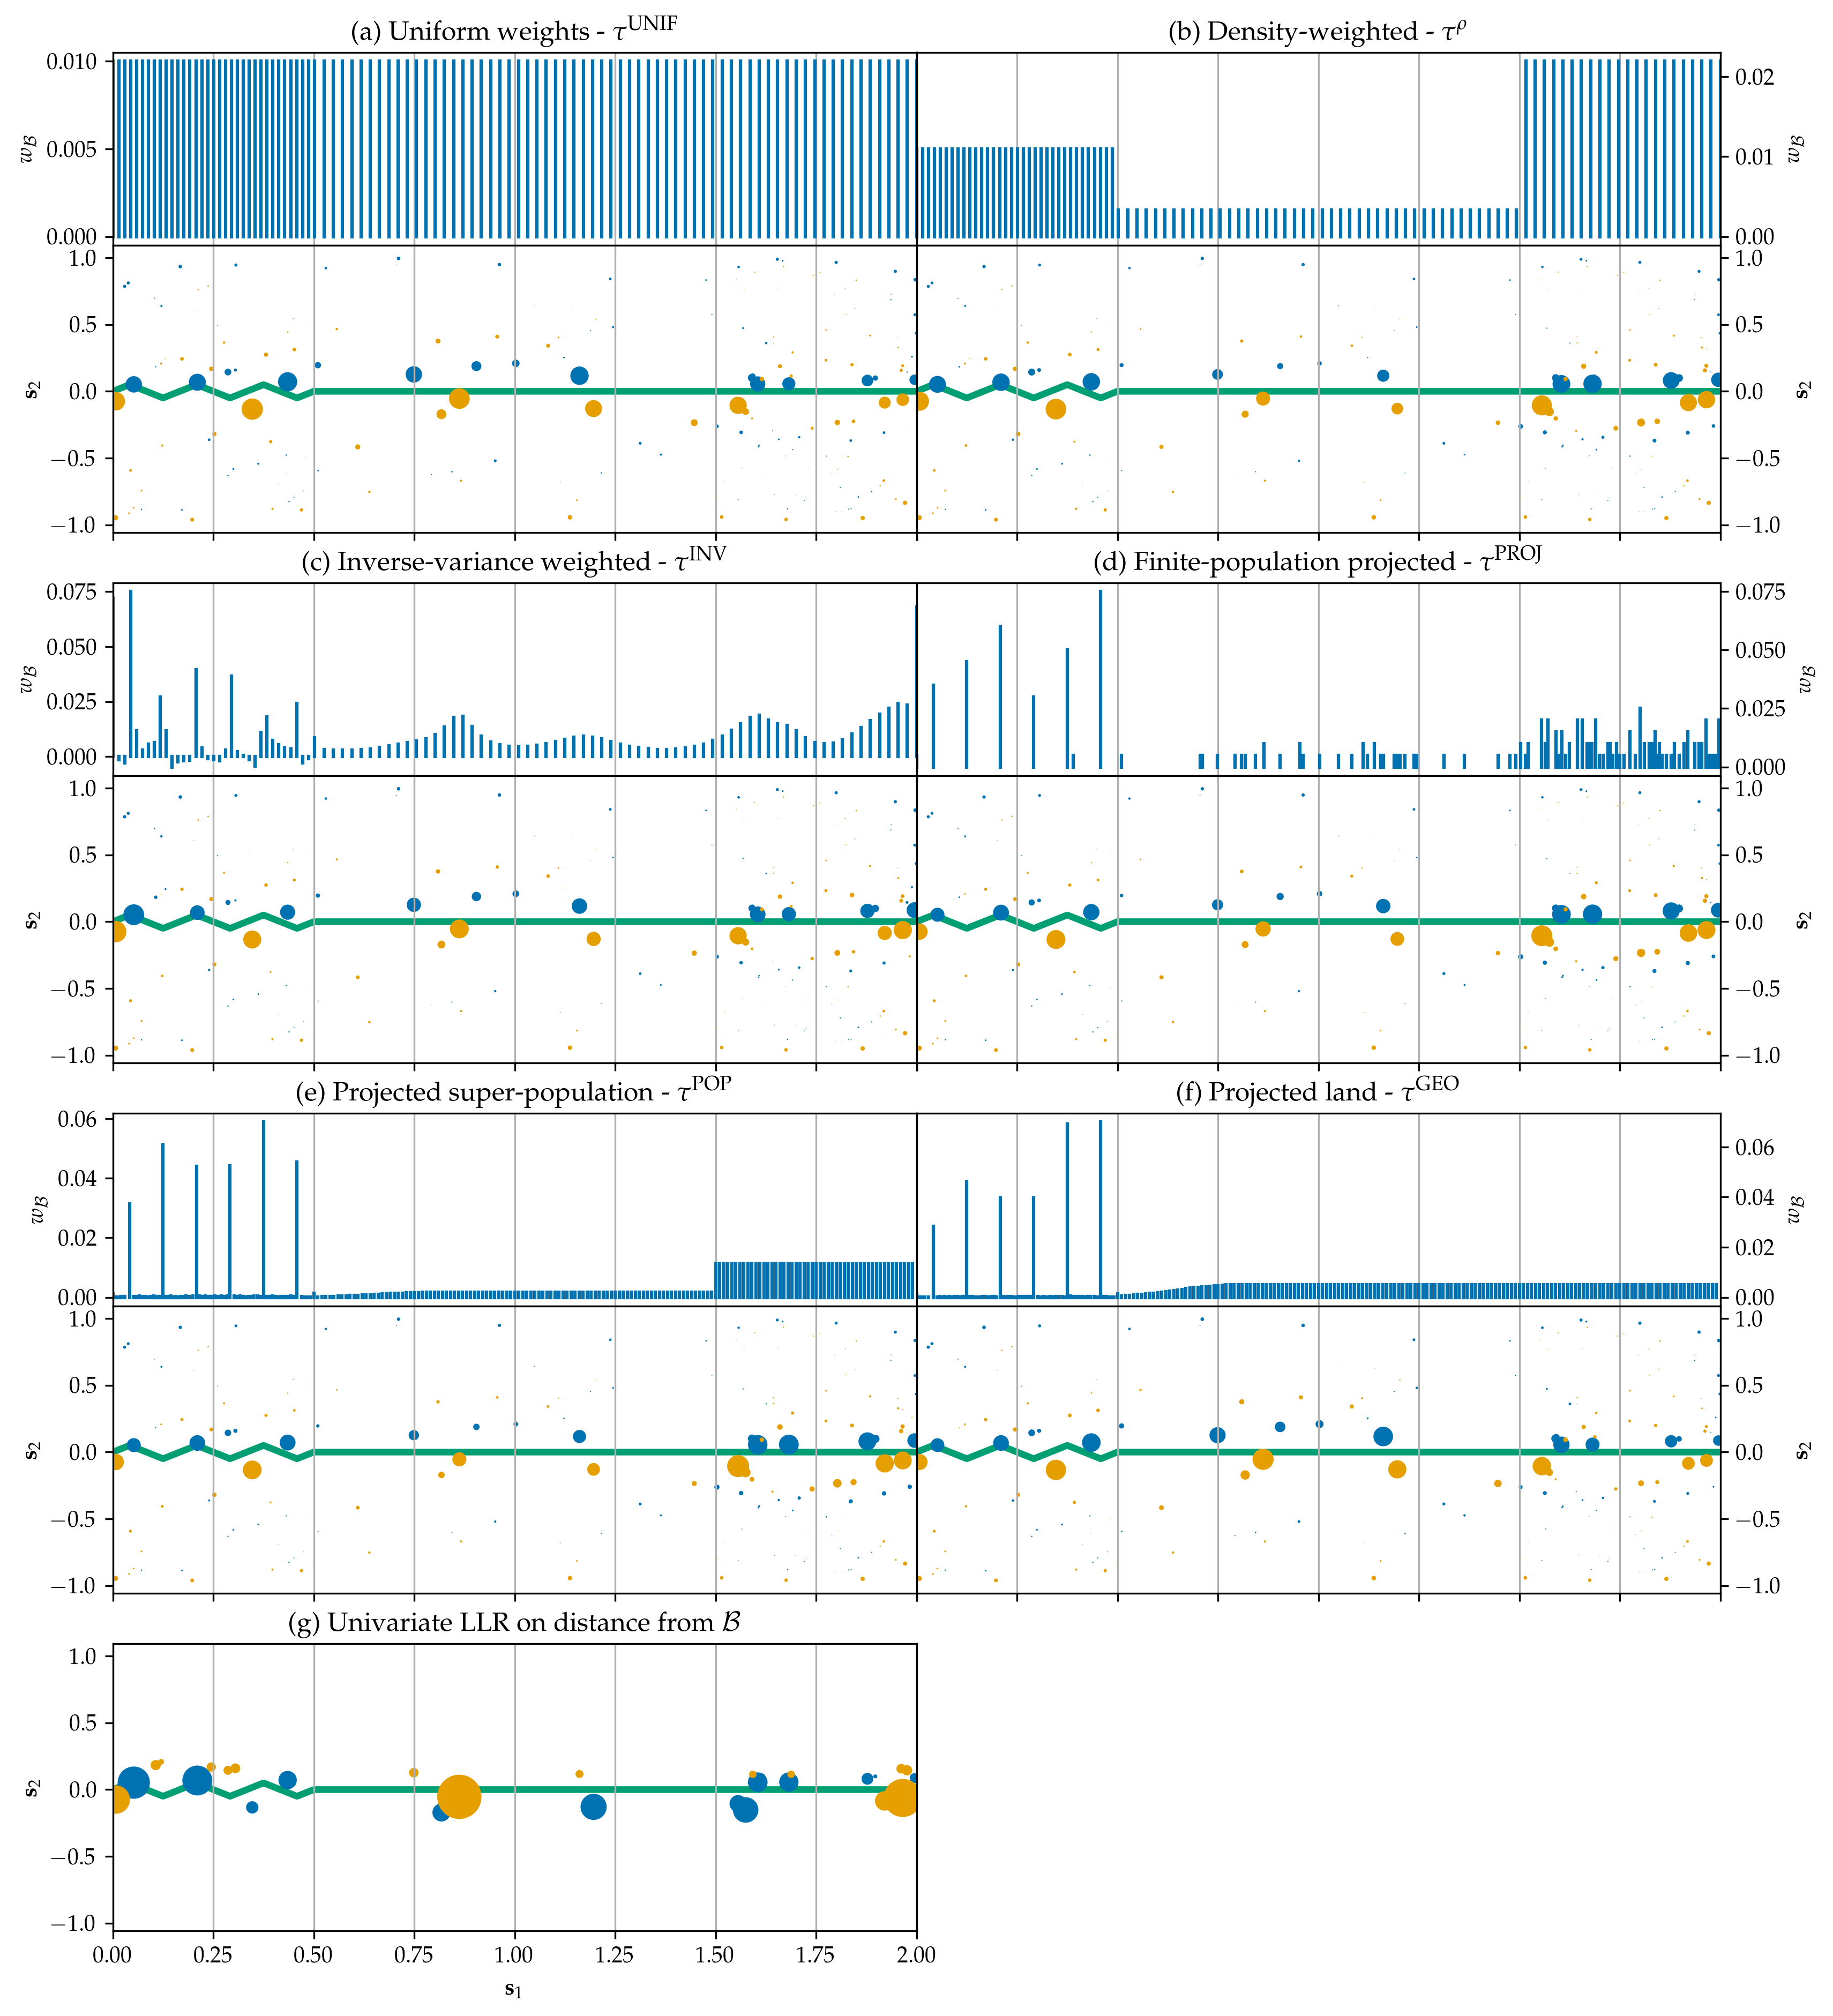

In [39]:
plt.gcf().set_size_inches(10, 12)
plt.subplots_adjust(left=0, right=1.0, bottom=0, top=1.0, hspace = 0.001)
ncol = 2

width = 0.5
height_border = 0.1
height_title = 0.026
height_unit = (1.0 - 3*height_border - 4*height_title) / 4
for (i,x) in enumerate((
            (plot_wunits_unif, L"(a) Uniform weights - $\tau^{\mathrm{UNIF}}$"),
            (plot_wunits_rho, L"(b) Density-weighted - $\tau^{\rho}$"),
            (plot_wunits_inv, L"(c) Inverse-variance weighted - $\tau^{\mathrm{INV}}$"),
            (plot_wunits_proj, L"(d) Finite-population projected - $\tau^{\mathrm{PROJ}}$"),
            (plot_wunits_pop, L"(e) Projected super-population - $\tau^{\mathrm{POP}}$"),
            (plot_wunits_geo, L"(f) Projected land - $\tau^{\mathrm{GEO}}$")
            ))
    plot_fun, title = x
    n_above, n_left = divrem(i-1, ncol)
    
    # Border weights
    bottom = 1.0 - n_above * (height_border+height_unit+height_title) - height_border - height_title
    left = width * n_left
    height = height_border
    top_axis = plt.axes([left, bottom, width, height])
    plt.sca(top_axis)
    
    plot_fun(wb_fit_treat, wb_fit_ctrol; on_border=true)
    plt.ylabel("")
    plt.ylabel(L"w_{\mathcal{B}}")
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.grid(axis="x")
    plt.title(title)
    plt.xlim(0.0, 2.0)
    
    # Unit weights
    bottom -= height_unit
    height = height_unit
    bottom_axis = plt.axes([left, bottom, width, height])
    plt.sca(bottom_axis)
    
    plot_fun(wb_fit_treat, wb_fit_ctrol; on_border=false)
    plt.grid(axis="x") 
    plt.ylabel("")
    plt.ylabel(L"\mathbf{s}_2")
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.xlim(0.0, 2.0)
    if n_left == (ncol-1)
        top_axis.yaxis.tick_right()
        top_axis.yaxis.set_label_position("right")
        bottom_axis.yaxis.tick_right()
        bottom_axis.yaxis.set_label_position("right")
    end
end

# projected LLR
# plt.subplot(4, ncol, 7)
bottom = 0.0
left = 0.0
height = height_unit
ax = plt.axes([left, bottom, width, height])
plt.sca(ax)

plt.title(L"(g) Univariate LLR on distance from $\mathcal{B}$")
plot_border(border)
plt.xlabel(L"\mathbf{s}_1")
plt.ylabel(L"\mathbf{s}_2")
plot_llr_unit_weights(wb_fit_treat, wb_fit_ctrol)
plt.grid(axis="x") 
plt.xlim(0.0, 2.0)
if do_savefig
    plt.savefig(joinpath(figures_dir, "weight_functions.png"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "weight_functions.pdf"), bbox_inches="tight")
end
;

## With Squared Exponential

In [40]:
k_se = SEIso(log(0.4), log(0.5))
k_se_const = Const(log(100.0)) + k_se

Type: SumKernel{Const{Float64},SEIso{Float64}}
  Type: Const{Float64}, Params: [4.605170185988092]  Type: SEIso{Float64}, Params: [-0.916290731874155, -0.6931471805599453]

In [41]:
wb_se_T = GPE(wbX_treat, collect(wb_Ytreat),  
                  MeanZero(), 
                  k_se_const, log(√wb_σy2))
wb_se_C = GPE(wbX_ctrol, collect(wb_Yctrol), 
                  MeanZero(), 
                  k_se_const, log(√wb_σy2))
;

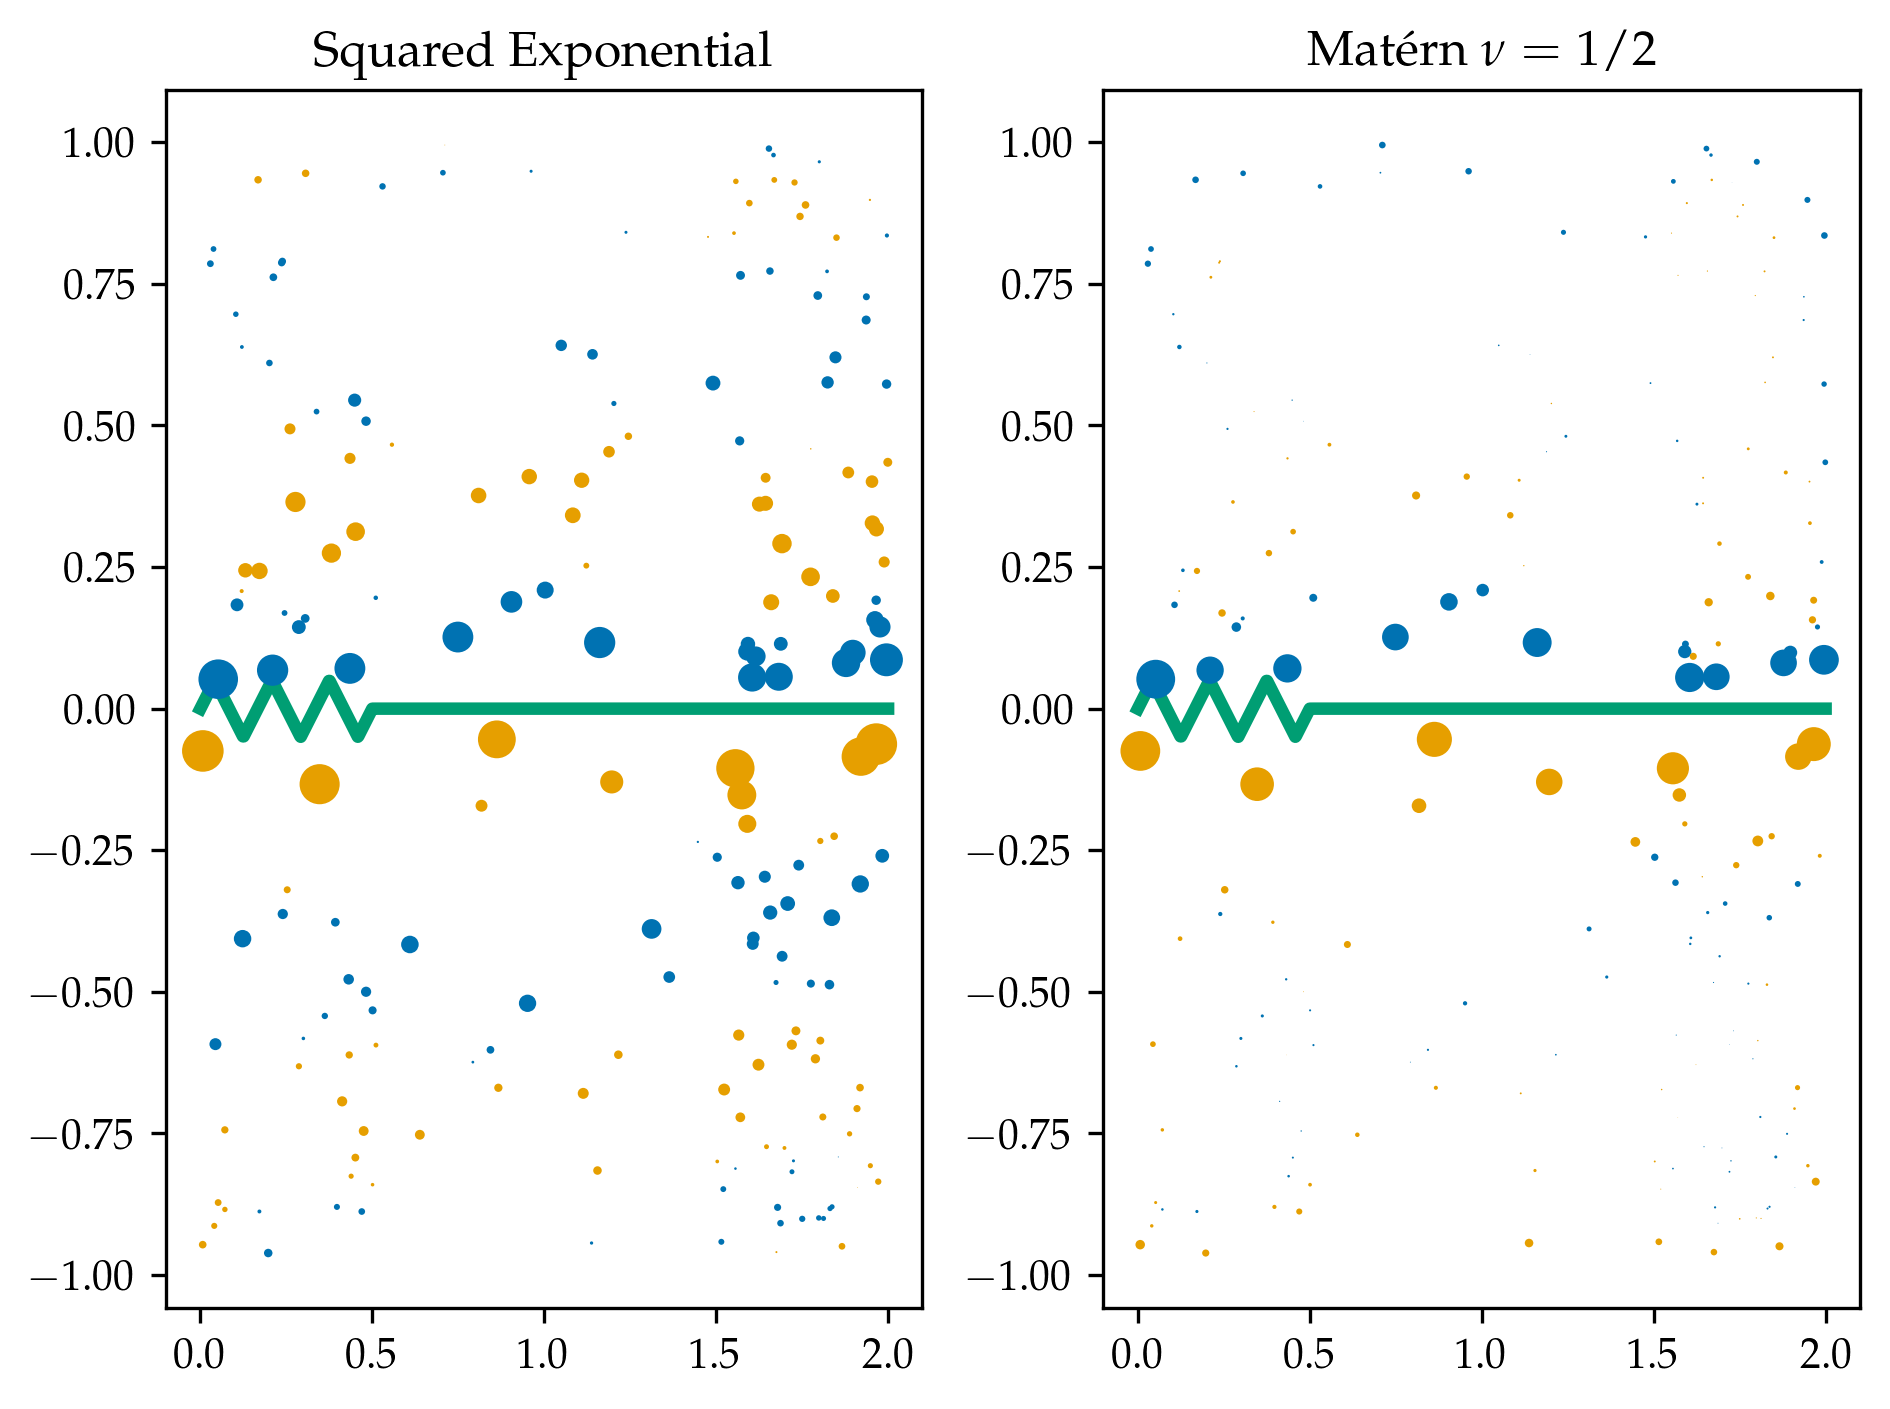

In [42]:
plt.subplot(1,2,1)
plot_wunits_inv(wb_se_T, wb_se_C)
plt.title("Squared Exponential")
plt.subplot(1,2,2)
plot_wunits_inv(wb_fit_treat, wb_fit_ctrol)
plt.title(L"Mat\'ern $\nu=1/2$")
;

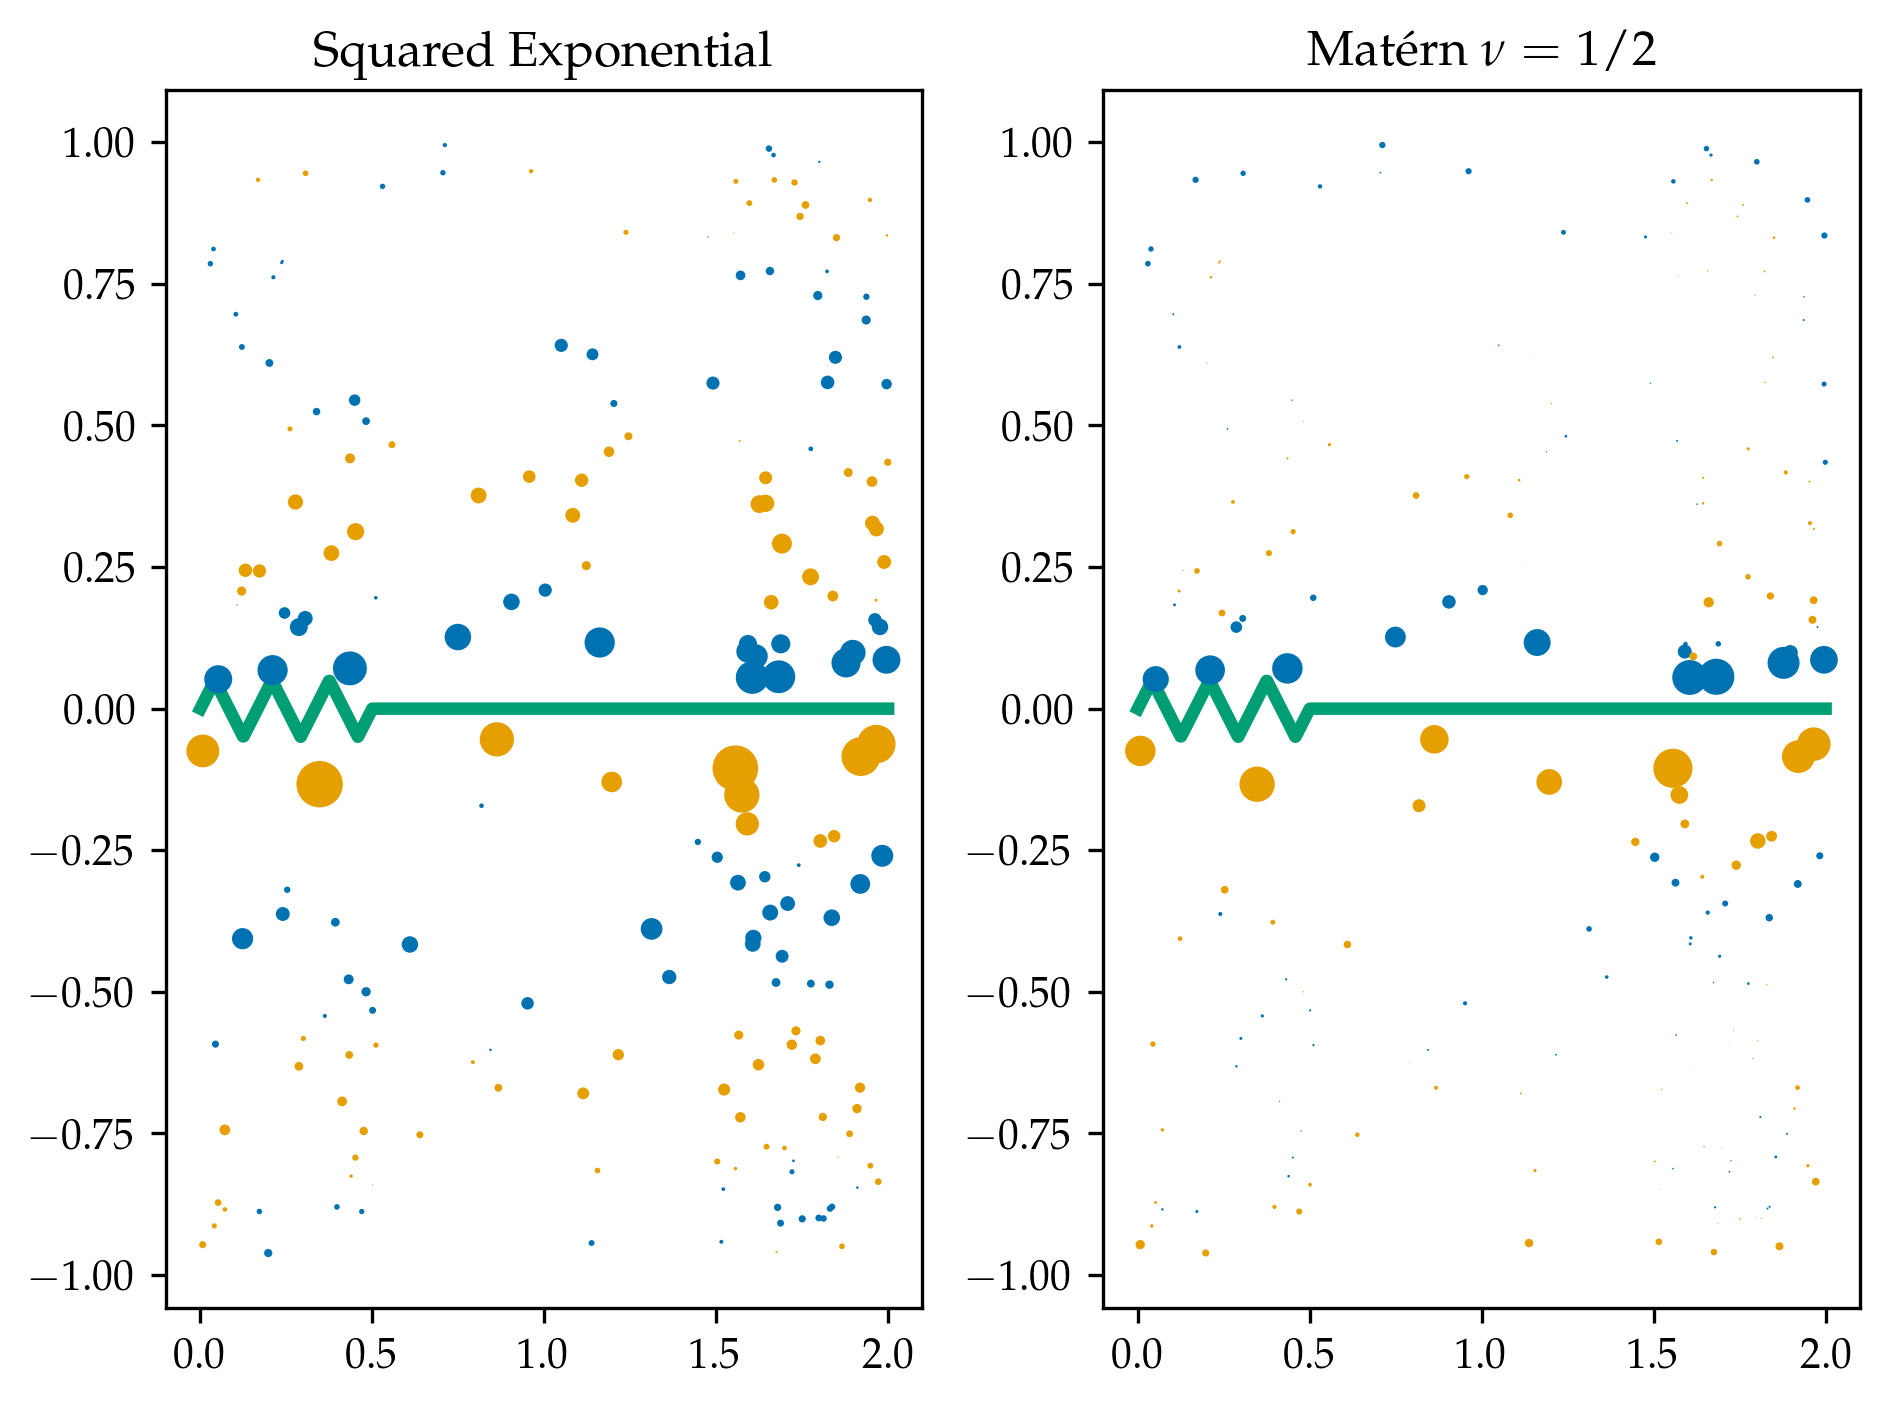

In [43]:
plt.subplot(1,2,1)
plot_wunits_proj(wb_se_T, wb_se_C)
plt.title("Squared Exponential")
plt.subplot(1,2,2)
plot_wunits_proj(wb_fit_treat, wb_fit_ctrol)
plt.title(L"Mat\'ern $\nu=1/2$")
;

The Matérn covariance does seem to put less weight on units further away from the border, which could be a good thing.
But then again that could just be a matter of different hyperparameters.

# Table

In [44]:
wb_nwiggles_arr = [0, 1, 2, 3, 5, 10, 20, 40, 80, 160, 320, 640, 1000]

import DataFrames
wiggly_df = DataFrames.DataFrame()
wiggly_df[!,:nwiggles] = wb_nwiggles_arr
for (iest, label) in enumerate([
        :unifavg,
        :invvar,
        :taurho,
        :tauproj,
        :taugeo,
        :taupop])
    y = [est[iest] for est in wb_mean_estimates]
#     y = [mean(wbe[iest]) for wbe in wb_estimates]
    y_err = [std(wbe[iest]) for wbe in wb_estimates]
    y_estimand = [mean(wbe[iest]) for wbe in estimands]
    
    str_y_se = [@sprintf("%.2f (%.2f)", x, xerr) 
                for (x,xerr) in zip(y, y_err)]
    str_y_estimand = [@sprintf("%.2f", x) for x in y_estimand]
    
    wiggly_df[!,Symbol("hat ", label)] = str_y_se
    wiggly_df[!,label] = str_y_estimand
end
print(repr("text/latex", wiggly_df))

\begin{tabular}{r|ccccccccccccc}
	& nwiggles & hat unifavg & unifavg & hat invvar & invvar & hat taurho & taurho & hat tauproj & tauproj & hat taugeo & taugeo & hat taupop & taupop\\
	\hline
	& Int64 & String & String & String & String & String & String & String & String & String & String & String & String\\
	\hline
	1 & 0 & 1.00 (0.18) & 1.00 & 1.03 (0.17) & 1.03 & 1.19 (0.19) & 1.21 & 1.16 (0.18) & 1.19 & 1.00 (0.18) & 1.00 & 1.19 (0.19) & 1.21 \\
	2 & 1 & 0.99 (0.18) & 0.99 & 1.02 (0.17) & 1.02 & 1.17 (0.19) & 1.19 & 1.16 (0.18) & 1.18 & 1.00 (0.18) & 1.00 & 1.19 (0.19) & 1.21 \\
	3 & 2 & 0.96 (0.18) & 0.95 & 1.01 (0.16) & 1.01 & 1.13 (0.18) & 1.14 & 1.16 (0.18) & 1.18 & 0.99 (0.18) & 0.99 & 1.19 (0.19) & 1.21 \\
	4 & 3 & 0.92 (0.18) & 0.91 & 1.00 (0.16) & 1.00 & 1.07 (0.18) & 1.08 & 1.16 (0.18) & 1.18 & 0.99 (0.18) & 0.99 & 1.18 (0.19) & 1.21 \\
	5 & 5 & 0.84 (0.18) & 0.82 & 1.00 (0.16) & 0.99 & 0.97 (0.18) & 0.96 & 1.16 (0.18) & 1.18 & 0.99 (0.18) & 0.99 & 1.19 (0.19) & 1.21 \\
	6

In [45]:
wiggly_df

,nwiggles,hat unifavg,unifavg,hat invvar,invvar,hat taurho,taurho,hat tauproj
,Int64,String,String,String,String,String,String,String
1,0,1.00 (0.18),1.00,1.03 (0.17),1.03,1.19 (0.19),1.21,1.16 (0.18)
2,1,0.99 (0.18),0.99,1.02 (0.17),1.02,1.17 (0.19),1.19,1.16 (0.18)
3,2,0.96 (0.18),0.95,1.01 (0.16),1.01,1.13 (0.18),1.14,1.16 (0.18)
4,3,0.92 (0.18),0.91,1.00 (0.16),1.00,1.07 (0.18),1.08,1.16 (0.18)
5,5,0.84 (0.18),0.82,1.00 (0.16),0.99,0.97 (0.18),0.96,1.16 (0.18)
6,10,0.71 (0.20),0.67,0.98 (0.16),0.97,0.79 (0.20),0.76,1.16 (0.18)
7,20,0.58 (0.22),0.52,0.97 (0.16),0.95,0.63 (0.22),0.58,1.16 (0.18)
8,40,0.48 (0.24),0.41,0.96 (0.16),0.95,0.50 (0.24),0.44,1.17 (0.18)
9,80,0.41 (0.26),0.34,0.96 (0.16),0.95,0.43 (0.26),0.35,1.16 (0.18)
